# 1: インポート

# 2: データ読込み

# 3: 特徴量数値化

# 4: ハイパーパラメータの調整

# 5: 実装

# 6: 過学習の有無を確認

# 1: インポート

In [1]:
import pandas as pd
from pandas import Series,DataFrame

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import numpy as np

import keras
from keras import regularizers
from keras.metrics import mae
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# 2: データの読み込み

In [115]:
data = pd.read_csv(rf'Linux5_8.csv',sep=",", header=0, encoding="CP932")
data.drop(data[["Bug ID"]], axis = 1, inplace=True) 
data.head(5)

Product  Component         Assignee  Status Resolution  \
0  Red Hat Enterprise Linux 5        yum     James Antill  CLOSED    NOTABUG   
1  Red Hat Enterprise Linux 6   pki-core  Matthew Harmsen  CLOSED     ERRATA   
2  Red Hat Enterprise Linux 6     kernel     Abhijith Das  CLOSED     ERRATA   
3  Red Hat Enterprise Linux 6   virt-v2v    Matthew Booth  CLOSED     ERRATA   
4  Red Hat Enterprise Linux 6  webkitgtk  Martin Stransky  CLOSED    NOTABUG   

                                             Summary           Changed  
0                                      yum won't run    2014/1/21 6:20  
1                   pki-symkey jar version incorrect   2011/5/19 13:43  
2  GFS2: allow gfs2 to update quota usage through...   2011/5/19 12:42  
3  virt-v2v should re-introduce support for Windo...  2018/11/14 13:01  
4          webkit do not cooperate with flash-plugin   2011/1/24 10:17

In [116]:
data.isnull().sum()

Product         0
Component       0
Assignee      909
Status          0
Resolution      0
Summary         0
Changed       120
dtype: int64

In [117]:
# "Assignee"と"Changed"が欠損値の箇所は削除

data.dropna(axis = 0, how = 'any', inplace=True)
data.head(5)

Product  Component         Assignee  Status Resolution  \
0  Red Hat Enterprise Linux 5        yum     James Antill  CLOSED    NOTABUG   
1  Red Hat Enterprise Linux 6   pki-core  Matthew Harmsen  CLOSED     ERRATA   
2  Red Hat Enterprise Linux 6     kernel     Abhijith Das  CLOSED     ERRATA   
3  Red Hat Enterprise Linux 6   virt-v2v    Matthew Booth  CLOSED     ERRATA   
4  Red Hat Enterprise Linux 6  webkitgtk  Martin Stransky  CLOSED    NOTABUG   

                                             Summary           Changed  
0                                      yum won't run    2014/1/21 6:20  
1                   pki-symkey jar version incorrect   2011/5/19 13:43  
2  GFS2: allow gfs2 to update quota usage through...   2011/5/19 12:42  
3  virt-v2v should re-introduce support for Windo...  2018/11/14 13:01  
4          webkit do not cooperate with flash-plugin   2011/1/24 10:17

# 3: 特徴量の数値化

In [118]:
# バグ修正完了している"CLOSED"なら1，それ以外を0

data["Status"].loc[data["Status"] == "CLOSED"] = 1
data["Status"].loc[data["Status"] != 1] = 0



# ["Product", "Component", "Assignee", "Resolution"]を，frequency encoding

freq_change = data[["Product", "Component", "Assignee", "Resolution"]]

for c in freq_change:
    freq = data[c].value_counts()
    
    # カテゴリの出現回数で置換
    data[c] = data[c].map(freq)
    data[c] = data[c] / len(data)

data.head(5)

Product  Component  Assignee Status  Resolution  \
0  0.068157   0.010332  0.003743      1    0.118971   
1  0.361025   0.005746  0.003005      1    0.414317   
2  0.361025   0.022403  0.000264      1    0.414317   
3  0.361025   0.001002  0.001265      1    0.414317   
4  0.361025   0.000053  0.005851      1    0.118971   

                                             Summary           Changed  
0                                      yum won't run    2014/1/21 6:20  
1                   pki-symkey jar version incorrect   2011/5/19 13:43  
2  GFS2: allow gfs2 to update quota usage through...   2011/5/19 12:42  
3  virt-v2v should re-introduce support for Windo...  2018/11/14 13:01  
4          webkit do not cooperate with flash-plugin   2011/1/24 10:17

In [119]:
# Changedを昇順に並び替える

data['Changed'] = pd.to_datetime(data['Changed'])
sort_data = data.sort_values(['Changed'])
sort_data.reset_index(drop=True, inplace=True)
sort_data.head(5)

Product  Component  Assignee Status  Resolution  \
0  0.361025   0.000053  0.005851      1    0.118971   
1  0.361025   0.041537  0.011966      1    0.122397   
2  0.361025   0.002108  0.004322      1    0.118971   
3  0.361025   0.022403  0.004428      1    0.118971   
4  0.361025   0.026303  0.001160      1    0.099626   

                                             Summary             Changed  
0          webkit do not cooperate with flash-plugin 2011-01-24 10:17:00  
1              not all UI widgets are RTL compatible 2011-01-27 21:21:00  
2  [abrt] coreutils-8.4-9.el6: __nanosleep_nocanc... 2011-02-04 14:24:00  
3                      ABRT reports crash after boot 2011-02-04 18:43:00  
4  hunspell-en is not in rhel-x86_64-server unlik... 2011-02-04 19:03:00

In [120]:
# 同Componentの修正間隔を求める

import datetime

sort_data["Changed"].astype(str)

Changed = sort_data["Changed"] # 変更日 
Component = sort_data["Component"] # Linuxのバージョン頻度 
sort_data["interval"] = 0
Different = sort_data["interval"]

Component[-1] = 0

for i in range(len(sort_data)): 
    Changed[i] = str(Changed[i]) 
    Changed[i] = Changed[i].replace(" ", "-") 
    Changed[i] = Changed[i].split("-")

    count = 0  # kのループを通過したかを判定
    
    
    # 途中経過
    if ((i % 2000) == 0):
        print(i)


    for j in range(i-1, -2, -1):

        if ((j == i-1) & (j >= 0)):
            for k in range(i-1, -1, -1):
                if ((Component[i] == Component[k]) & (int(Changed[i][1]) == int(Changed[k][1])) & 
                    (int(Changed[i][2]) == int(Changed[k][2])) & (i > 0) & (k > 0)):
                    
                    Different[i] = Different[k]
                    sort_data["interval"][i] = Different[i]
                    count = count + 1
                    break


        if ((Component[i] == Component[j]) & (i > 0) & (count == 0)):
            criterion = datetime.date(int(Changed[j][0]), int(Changed[j][1]), int(Changed[j][2]))
            current = datetime.date(int(Changed[i][0]), int(Changed[i][1]), int(Changed[i][2]))
            Different[i] = (current - criterion).days
            sort_data["interval"][i] = Different[i]
            break

        elif (((j == 0) | (i == 0)) & (count == 0)):
            Different[i] = 0
            sort_data["interval"][i] = 0
            break

0
2000
4000
6000
8000
10000
12000
14000
16000
18000


In [131]:
data = sort_data.drop(sort_data[["Changed"]], axis = 1, inplace=True) 

# 可能なら，形態素解析など行う(現在は文字列の長さ)
for i in range(len(data)):
    data["Summary"][i] = len(data["Summary"][i])


data["target"] = sort_data["Product"] * sort_data["Component"]

data.head(5)

Product  Component  Assignee Status  Resolution Summary  interval  \
0  0.361025   0.000053  0.005851      1    0.118971      41         0   
1  0.361025   0.041537  0.011966      1    0.122397      37         0   
2  0.361025   0.002108  0.004322      1    0.118971     101         0   
3  0.361025   0.022403  0.004428      1    0.118971      29         0   
4  0.361025   0.026303  0.001160      1    0.099626      75         0   

     target  
0  0.000019  
1  0.014996  
2  0.000761  
3  0.008088  
4  0.009496

In [132]:
# ファイル書き出し
data.to_csv(rf'data.csv',index = False)

In [2]:
data_set = pd.read_csv(rf'data.csv',sep=",", header=0)

x = DataFrame(data_set.drop(data_set[["Product", "Component", "target"]], axis=1))
y = DataFrame(data_set["target"])


tr_x ,va_x ,tr_y ,va_y = train_test_split(x,y,test_size=0.2, shuffle=False)

# 4: ハイパーパラメータの調整

In [5]:
from hyperopt import hp
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import ReLU, PReLU
from keras.layers.core import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from sklearn.preprocessing import StandardScaler

# 基本となるパラメータ
base_param = {
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 96,
    'hidden_activation': 'relu',
    'hidden_dropout': 0.2,
    'batch_norm': 'before_act',
    'optimizer': {'type': 'adam', 'lr': 0.001},
    'batch_size': 64,
    #'regularizers': 0.01
}

# 探索するパラメータの空間を指定する
param_space = {
    'input_dropout': hp.quniform('input_dropout', 0, 0.1, 0.05),
    'hidden_layers': hp.quniform('hidden_layers', 2, 5, 1),
    'hidden_units': hp.quniform('hidden_units', 32, 256, 32),
    'hidden_activation': hp.choice('hidden_activation', ['prelu', 'relu']),
    'hidden_dropout': hp.quniform('hidden_dropout', 0, 0.3, 0.05),
    'batch_norm': hp.choice('batch_norm', ['before_act', 'no']),
    #'regularizers': hp.quniform('regularizers', 0, 0.2, 0.05),
    'optimizer': hp.choice('optimizer',
                           [{'type': 'adam',
                             'lr': hp.loguniform('adam_lr', np.log(0.00001), np.log(0.01))},
                            {'type': 'adagrad',
                             'lr': hp.loguniform('adagrad_lr', np.log(0.00001), np.log(0.01))},
                            {'type': 'adadelta',
                             'lr': hp.loguniform('adadelta_lr', np.log(0.00001), np.log(0.01))},
                            {'type': 'adamax',
                             'lr': hp.loguniform('adamax_lr', np.log(0.00001), np.log(0.01))}]),
    'batch_size': hp.quniform('batch_size', 32, 128, 32),
}

In [ ]:
# 正則化加える途中

class MLP:

    def __init__(self, params):
        self.params = params
        self.scaler = None
        self.model = None

    def fit(self, tr_x, tr_y, va_x, va_y):

        # パラメータ
        input_dropout = self.params['input_dropout']
        hidden_layers = int(self.params['hidden_layers'])
        hidden_units = int(self.params['hidden_units'])
        hidden_activation = self.params['hidden_activation']
        hidden_dropout = self.params['hidden_dropout']
        batch_norm = self.params['batch_norm']
        optimizer_type = self.params['optimizer']['type']
        optimizer_lr = self.params['optimizer']['lr']
        batch_size = int(self.params['batch_size'])
        #regularizers = self.params['regularizers']

        # 標準化
        self.scaler = StandardScaler()
        tr_x = self.scaler.fit_transform(tr_x)
        va_x = self.scaler.transform(va_x)

        self.model = Sequential()

        # 入力層
        self.model.add(Dropout(input_dropout, input_shape=(tr_x.shape[1],)))

        # 中間層
        for i in range(hidden_layers):
            self.model.add(Dense(hidden_units))
            if batch_norm == 'before_act':
                self.model.add(BatchNormalization())
            if hidden_activation == 'prelu':
                self.model.add(PReLU())
            elif hidden_activation == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(hidden_dropout))

        # 出力層
        self.model.add(Dense(1))

        # オプティマイザ
        if optimizer_type == 'adam':
            optimizer = Adam(lr=optimizer_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.)
        elif optimizer_type == 'adadelta':
            optimizer = Adadelta(lr=optimizer_lr, rho=0.95, epsilon=1e-07, decay=0.0)
        elif optimizer_type == 'adamax':
            optimizer = Adamax(lr=optimizer_lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
        elif optimizer_type == 'adagrad':
            optimizer = Adagrad(lr=optimizer_lr, epsilon=1e-07, decay=0.0)
        else:
            raise NotImplementedError
            

        # 目的関数、評価指標などの設定
        
        self.model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mae'])

        # エポック数、アーリーストッピング
        nb_epoch = 50
        patience = 20
        early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

        # 学習の実行
        history = self.model.fit(tr_x, tr_y,
                                 epochs=nb_epoch,
                                 batch_size=batch_size, verbose=1,
                                 validation_data=(va_x, va_y),
                                 callbacks=[early_stopping])

    def predict(self, x):
        # 予測
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred



    
    

from hyperopt import fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import log_loss
from sklearn.metrics import mean_absolute_error


def score(params):
    # パラメータセットを指定したときに最小化すべき関数を指定する
    # モデルのパラメータ探索においては、モデルにパラメータを指定して学習・予測させた場合のスコアとする
    model = MLP(params)
    model.fit(tr_x, tr_y, va_x, va_y)
    va_pred = model.predict(va_x)
    score = mean_absolute_error(va_y, va_pred)
    print(f'params: {params}, MAE: {score:.4f}')

    # 情報を記録しておく
    history.append((params, score))

    return {'loss': score, 'status': STATUS_OK}


# hyperoptによるパラメータ探索の実行
max_evals = 10
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)


# 記録した情報からパラメータとスコアを出力する
# trialsからも情報が取得できるが、パラメータを取得しにくい
history = sorted(history, key=lambda tpl: tpl[1])
best = history[0]
print(f'best params:{best[0]}, score:{best[1]:.4f}')

Train on 15176 samples, validate on 3795 samples                                                                       
Epoch 1/50                                                                                                             
   64/15176 [..............................]                                                                           
 - ETA: 1:24 - loss: 0.0527 - mae: 0.0527                                                                              
                                                                                                                       
  384/15176 [..............................]                                                                           
 - ETA: 15s - loss: 0.0533 - mae: 0.0533                                                                               
                                                                                                                      
  576/15176 [>...........................

 7616/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0417 - mae: 0.0417                                                                                
                                                                                                                       
 7872/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0414 - mae: 0.0414                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0413 - mae: 0.0413                                                                                
                                        

                                                                                                                       
 2176/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0187 - mae: 0.0187                                                                                
                                                                                                                       
 2752/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0183 - mae: 0.0183                                                                                
                                                                                                                       
 3136/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0183 - mae: 0.0183 

 - ETA: 0s - loss: 0.0165 - mae: 0.0165                                                                                
                                                                                                                       
11136/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0163 - mae: 0.0163                                                                                
                                                                                                                       
11776/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0163 - mae: 0.0163                                                                                
                                                                                                                       
12096/15176 [======================>....

 3328/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0133 - mae: 0.0133                                                                                
                                                                                                                       
 3712/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.0133 - mae: 0.0133                                                                                
                                                                                                                       
 4160/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0133 - mae: 0.0133                                                                                
                                        

                                                                                                                       
13120/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0121 - mae: 0.0121                                                                                
                                                                                                                       
13632/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0121 - mae: 0.0121                                                                                
                                                                                                                       
14144/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0120 - mae: 0.0120 

 - ETA: 0s - loss: 0.0102 - mae: 0.0102                                                                                
                                                                                                                       
 8960/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0102 - mae: 0.0102                                                                                
                                                                                                                       
 9600/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0102 - mae: 0.0102                                                                                
                                                                                                                       
10176/15176 [===================>.......

 3008/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0088 - mae: 0.0088                                                                                
                                                                                                                       
 3520/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0089 - mae: 0.0089                                                                                
                                                                                                                       
 3968/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.0090 - mae: 0.0090                                                                                
                                        

                                                                                                                       
11712/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0087 - mae: 0.0087                                                                                
                                                                                                                       
12288/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0087 - mae: 0.0087                                                                                
                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0087 - mae: 0.0087 

 - ETA: 1s - loss: 0.0082 - mae: 0.0082                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0082 - mae: 0.0082                                                                                
                                                                                                                       
 5632/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0082 - mae: 0.0082                                                                                
                                                                                                                       
 6016/15176 [==========>................

12352/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0080 - mae: 0.0080                                                                                
                                                                                                                       
12672/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0080 - mae: 0.0080                                                                                
                                                                                                                       
12992/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0080 - mae: 0.0080                                                                                
                                        

                                                                                                                       
 5056/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0075 - mae: 0.0075                                                                                
                                                                                                                       
 5568/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0075 - mae: 0.0075                                                                                
                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0075 - mae: 0.0075 

 - ETA: 0s - loss: 0.0074 - mae: 0.0074                                                                                
                                                                                                                       
13312/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0074 - mae: 0.0074                                                                                
                                                                                                                       
13760/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0074 - mae: 0.0074                                                                                
                                                                                                                       
14208/15176 [===========================

 5888/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0072 - mae: 0.0072                                                                                
                                                                                                                       
 6400/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0072 - mae: 0.0072                                                                                
                                                                                                                       
 6848/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0072 - mae: 0.0072                                                                                
                                        

Epoch 9/50                                                                                                             
   64/15176 [..............................]                                                                           
 - ETA: 2s - loss: 0.0066 - mae: 0.0066                                                                                
                                                                                                                       
  768/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0067 - mae: 0.0067                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0069 - mae: 0.0069 

 - ETA: 0s - loss: 0.0069 - mae: 0.0069                                                                                
                                                                                                                       
10496/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0069 - mae: 0.0069                                                                                
                                                                                                                       
11136/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0069 - mae: 0.0069                                                                                
                                                                                                                       
11648/15176 [======================>....

 5248/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0067 - mae: 0.0067                                                                                
                                                                                                                       
 5632/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0067 - mae: 0.0067                                                                                
                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0067 - mae: 0.0067                                                                                
                                        

                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 127us/step - loss: 0.0067 - mae: 0.0067 - val_loss: 0.0175 - val_mae: 0.0175                                     

Epoch 11/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0081 - mae: 0.0081                                                                                
                                                                                                                       
  576/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0070 - mae: 0.0070

 - ETA: 0s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
10112/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
10688/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
11200/15176 [=====================>.....

 3968/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0065 - mae: 0.0065                                                                                
                                        

                                                                                                                       
14464/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0064 - mae: 0.0064                                                                                
                                                                                                                       
14912/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0064 - mae: 0.0064                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 125us/step - loss: 0.0064 - mae: 0

 - ETA: 0s - loss: 0.0062 - mae: 0.0062                                                                                
                                                                                                                       
 9216/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0062 - mae: 0.0062                                                                                
                                                                                                                       
 9728/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.0062 - mae: 0.0062                                                                                
                                                                                                                       
10240/15176 [===================>.......

 4096/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0061 - mae: 0.0061                                                                                
                                                                                                                       
 4544/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0061 - mae: 0.0061                                                                                
                                                                                                                       
 5056/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0061 - mae: 0.0061                                                                                
                                        

                                                                                                                       
14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0061 - mae: 0.0061                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 118us/step - loss: 0.0061 - mae: 0.0061 - val_loss: 0.0173 - val_mae: 0.0173                                     

Epoch 15/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 0s - loss: 0.0056 - mae: 0.0056

 - ETA: 0s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
10432/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
10816/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
11392/15176 [=====================>.....

 5376/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0059 - mae: 0.0059                                                                                
                                                                                                                       
 5824/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0059 - mae: 0.0059                                                                                
                                                                                                                       
 6272/15176 [===========>..................]                                                                           
 - ETA: 0s - loss: 0.0059 - mae: 0.0059                                                                                
                                        

                                                                                                                       
 1088/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 0.0057 - mae: 0.0057                                                                                
                                                                                                                       
 2176/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0057 - mae: 0.0057 

 - ETA: 0s - loss: 0.0058 - mae: 0.0058                                                                                
                                                                                                                       
12288/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0058 - mae: 0.0058                                                                                
                                                                                                                       
12928/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0058 - mae: 0.0058                                                                                
                                                                                                                       
13440/15176 [=========================>.

 7168/15176 [=============>................]                                                                           
 - ETA: 0s - loss: 0.0058 - mae: 0.0058                                                                                
                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0058 - mae: 0.0058                                                                                
                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0058 - mae: 0.0058                                                                                
                                        

                                                                                                                       
 2368/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0059 - mae: 0.0059                                                                                
                                                                                                                       
 2816/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0059 - mae: 0.0059                                                                                
                                                                                                                       
 3328/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0058 - mae: 0.0058 

 - ETA: 0s - loss: 0.0057 - mae: 0.0057                                                                                
                                                                                                                       
13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0057 - mae: 0.0057                                                                                
                                                                                                                       
13760/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0057 - mae: 0.0057                                                                                
                                                                                                                       
14272/15176 [===========================

 8576/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
 9216/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
 9792/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.0056 - mae: 0.0056                                                                                
                                        

                                                                                                                       
 3392/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 3968/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0055 - mae: 0.0055 

 - ETA: 0s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
12160/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
12608/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
12928/15176 [========================>..

 4864/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
 5440/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0056 - mae: 0.0056                                                                                
                                                                                                                       
 5760/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0056 - mae: 0.0056                                                                                
                                        

                                                                                                                       
14656/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
15104/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 133us/step - loss: 0.0055 - mae: 0

 - ETA: 1s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 8640/15176 [================>..........

 2048/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0057 - mae: 0.0057                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0057 - mae: 0.0057                                                                                
                                                                                                                       
 3008/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0057 - mae: 0.0057                                                                                
                                        

                                                                                                                       
11456/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
11904/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
12288/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0055 - mae: 0.0055 

 - ETA: 1s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 5760/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 6208/15176 [===========>...............

13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
13760/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
14208/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0054 - mae: 0.0054                                                                                
                                        

                                                                                                                       
 6912/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 7296/15176 [=============>................]                                                                           
 - ETA: 0s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0054 - mae: 0.0054 

 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
  704/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 1216/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0055 - mae: 0.0055                                                                                
                                                                                                                       
 1728/15176 [==>........................

10560/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
11136/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
11584/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                        

                                                                                                                       
 6208/15176 [===========>..................]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 7360/15176 [=============>................]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053 

 - ETA: 1s - loss: 0.0042 - mae: 0.0042                                                                                
                                                                                                                       
  768/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 1792/15176 [==>........................

11584/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
12096/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                        

                                                                                                                       
 5824/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 6208/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 6528/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0053 - mae: 0.0053 

 - ETA: 0s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 140us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0134 - val_mae: 0.0134                                     

Epoch 31/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
  704/15176 [>.........................

10368/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
10816/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
11328/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0052 - mae: 0.0052                                                                                
                                        

                                                                                                                       
 5632/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 0s - loss: 0.0052 - mae: 0.0052 

 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 1792/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 2176/15176 [===>.......................

11776/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
12224/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                        

                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051 

 - ETA: 1s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
 2880/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 3392/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
 3968/15176 [======>....................

14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
14848/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 108us/step - loss: 0.0051 - mae: 0.0051 - val_loss: 0.0147 - val_mae: 0.0147                                     

Epoch 36/50                            

                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 9088/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 9664/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051 

 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 2240/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 2624/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 2944/15176 [====>......................

11392/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
11968/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0051 - mae: 0.0051                                                                                
                                        

                                                                                                                       
 5440/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 5888/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 6272/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050 

 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
14720/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 131us/step - loss: 0.0050 - mae: 0.0050 - val_loss: 0.0144 - val_mae: 0.0144                                     

Epoch 39/50                                                                                                            
   64/15176 [..........................

 8256/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 8640/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                        

                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 2048/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 2496/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049 

 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
10624/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
11072/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
11392/15176 [=====================>.....

 3904/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                        

                                                                                                                       
13760/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
14720/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050 

 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 7552/15176 [=============>................]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 8576/15176 [===============>...........

  832/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0051 - mae: 0.0051                                                                                
                                                                                                                       
 1344/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 1792/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                        

                                                                                                                       
10304/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
10816/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049 

 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 5120/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 5760/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 6208/15176 [===========>...............

13760/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
14272/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                        

                                                                                                                       
 7872/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 8704/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0048 - mae: 0.0048 

 - ETA: 2s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 1408/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 1792/15176 [==>........................

10176/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
10688/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
11328/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                        

                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0048 - mae: 0.0048 

 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
15040/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
15176/15176 [===========================

 7744/15176 [==============>...............]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 8192/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 8704/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                        

                                                                                                                       
 1472/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 1984/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0048 - mae: 0.0048 

 - ETA: 0s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
10880/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
11904/15176 [======================>....

 3776/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 4992/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                        

                                                                                                                       
13376/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
14528/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0048 - mae: 0.0048 

 - ETA: 1s - loss: 0.1677 - mae: 0.1677                                                                                
                                                                                                                       
 5568/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.1660 - mae: 0.1660                                                                                
                                                                                                                       
 5952/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.1649 - mae: 0.1649                                                                                
                                                                                                                       
 6208/15176 [===========>...............

13184/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.1549 - mae: 0.1549                                                                                
                                                                                                                       
13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.1547 - mae: 0.1547                                                                                
                                                                                                                       
14016/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.1543 - mae: 0.1543                                                                                
                                        

                                                                                                                       
 4992/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.1337 - mae: 0.1337                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.1337 - mae: 0.1337                                                                                
                                                                                                                       
 5696/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.1334 - mae: 0.1334 

 - ETA: 0s - loss: 0.1319 - mae: 0.1319                                                                                
                                                                                                                       
12928/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.1320 - mae: 0.1320                                                                                
                                                                                                                       
13312/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.1316 - mae: 0.1316                                                                                
                                                                                                                       
13696/15176 [==========================>

 5632/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.1232 - mae: 0.1232                                                                                
                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.1240 - mae: 0.1240                                                                                
                                                                                                                       
 6464/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.1248 - mae: 0.1248                                                                                
                                        

                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.1237 - mae: 0.1237                                                                                
                                                                                                                       
14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.1236 - mae: 0.1236                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 142us/step - loss: 0.1237 - mae: 0

 - ETA: 1s - loss: 0.1206 - mae: 0.1206                                                                                
                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.1211 - mae: 0.1211                                                                                
                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1214 - mae: 0.1214                                                                                
                                                                                                                       
 7936/15176 [==============>............

14464/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.1204 - mae: 0.1204                                                                                
                                                                                                                       
14848/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.1202 - mae: 0.1202                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 158us/step - loss: 0.1199 - mae: 0.1199 - val_loss: 0.0488 - val_mae: 0.0488                                     

Epoch 5/50                             

                                                                                                                       
 7488/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.1166 - mae: 0.1166                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1160 - mae: 0.1160                                                                                
                                                                                                                       
 8192/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.1162 - mae: 0.1162 

 - ETA: 0s - loss: 0.1146 - mae: 0.1146                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 155us/step - loss: 0.1146 - mae: 0.1146 - val_loss: 0.0427 - val_mae: 0.0427                                     

Epoch 6/50                                                                                                             
   64/15176 [..............................]                                                                           
 - ETA: 2s - loss: 0.1157 - mae: 0.1157                                                                                
                                                                                                                       
  320/15176 [..........................

 7232/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.1109 - mae: 0.1109                                                                                
                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1111 - mae: 0.1111                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1111 - mae: 0.1111                                                                                
                                        

                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 158us/step - loss: 0.1108 - mae: 0.1108 - val_loss: 0.0398 - val_mae: 0.0398                                     

Epoch 7/50                                                                                                             
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.1270 - mae: 0.1270                                                                                
                                                                                                                       
  448/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.1097 - mae: 0.1097

 - ETA: 1s - loss: 0.1082 - mae: 0.1082                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1087 - mae: 0.1087                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.1085 - mae: 0.1085                                                                                
                                                                                                                       
 8768/15176 [================>..........

   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0878 - mae: 0.0878                                                                                
                                                                                                                       
  384/15176 [..............................]                                                                           
 - ETA: 2s - loss: 0.1088 - mae: 0.1088                                                                                
                                                                                                                       
  704/15176 [>.............................]                                                                           
 - ETA: 2s - loss: 0.1088 - mae: 0.1088                                                                                
                                        

                                                                                                                       
 7552/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.1074 - mae: 0.1074                                                                                
                                                                                                                       
 8000/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1070 - mae: 0.1070                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 1s - loss: 0.1075 - mae: 0.1075 

 - 2s 161us/step - loss: 0.1071 - mae: 0.1071 - val_loss: 0.0361 - val_mae: 0.0361                                     

Epoch 9/50                                                                                                             
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.1004 - mae: 0.1004                                                                                
                                                                                                                       
  512/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.1033 - mae: 0.1033                                                                                
                                                                                                                       
  768/15176 [>.........................

 7616/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1035 - mae: 0.1035                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1041 - mae: 0.1041                                                                                
                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.1040 - mae: 0.1040                                                                                
                                        

Epoch 10/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.1039 - mae: 0.1039                                                                                
                                                                                                                       
  448/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0990 - mae: 0.0990                                                                                
                                                                                                                       
  832/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0977 - mae: 0.0977 

 - ETA: 1s - loss: 0.1033 - mae: 0.1033                                                                                
                                                                                                                       
 7552/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.1032 - mae: 0.1032                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1033 - mae: 0.1033                                                                                
                                                                                                                       
 8384/15176 [===============>...........

   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0917 - mae: 0.0917                                                                                
                                                                                                                       
  448/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0979 - mae: 0.0979                                                                                
                                                                                                                       
  832/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.1005 - mae: 0.1005                                                                                
                                        

                                                                                                                       
 7744/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0998 - mae: 0.0998                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 1s - loss: 0.0999 - mae: 0.0999                                                                                
                                                                                                                       
 8576/15176 [===============>..............]                                                                           
 - ETA: 1s - loss: 0.0999 - mae: 0.0999 

 - 2s 161us/step - loss: 0.0987 - mae: 0.0987 - val_loss: 0.0323 - val_mae: 0.0323                                     

Epoch 12/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 2s - loss: 0.1073 - mae: 0.1073                                                                                
                                                                                                                       
  448/15176 [..............................]                                                                           
 - ETA: 2s - loss: 0.0961 - mae: 0.0961                                                                                
                                                                                                                       
  704/15176 [>.........................

 7552/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.1010 - mae: 0.1010                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.1009 - mae: 0.1009                                                                                
                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 1s - loss: 0.1009 - mae: 0.1009                                                                                
                                        

                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 163us/step - loss: 0.0995 - mae: 0.0995 - val_loss: 0.0315 - val_mae: 0.0315                                     

Epoch 13/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0760 - mae: 0.0760                                                                                
                                                                                                                       
  448/15176 [..............................]                                                                           
 - ETA: 2s - loss: 0.0906 - mae: 0.0906

 - ETA: 1s - loss: 0.0961 - mae: 0.0961                                                                                
                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0969 - mae: 0.0969                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0971 - mae: 0.0971                                                                                
                                                                                                                       
 8128/15176 [===============>...........

15176/15176 [==============================]                                                                           
 - 2s 159us/step - loss: 0.0967 - mae: 0.0967 - val_loss: 0.0291 - val_mae: 0.0291                                     

Epoch 14/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.1035 - mae: 0.1035                                                                                
                                                                                                                       
  576/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.1041 - mae: 0.1041                                                                                
                                       

                                                                                                                       
 8000/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0965 - mae: 0.0965                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0966 - mae: 0.0966                                                                                
                                                                                                                       
 8768/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0963 - mae: 0.0963 

 - ETA: 1s - loss: 0.0931 - mae: 0.0931                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0973 - mae: 0.0973                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0948 - mae: 0.0948                                                                                
                                                                                                                       
 1664/15176 [==>........................

 6464/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0929 - mae: 0.0929                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0928 - mae: 0.0928                                                                                
                                                                                                                       
 6720/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0928 - mae: 0.0928                                                                                
                                        

                                                                                                                       
11584/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0934 - mae: 0.0934                                                                                
                                                                                                                       
11776/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0931 - mae: 0.0931                                                                                
                                                                                                                       
12096/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0933 - mae: 0.0933 

 - ETA: 2s - loss: 0.0934 - mae: 0.0934                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 2s - loss: 0.0941 - mae: 0.0941                                                                                
                                                                                                                       
 2688/15176 [====>.........................]                                                                           
 - ETA: 2s - loss: 0.0931 - mae: 0.0931                                                                                
                                                                                                                       
 2752/15176 [====>......................

 7424/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
 7616/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0908 - mae: 0.0908                                                                                
                                        

                                                                                                                       
13184/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0914 - mae: 0.0914                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0917 - mae: 0.0917                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0918 - mae: 0.0918 

 - ETA: 3s - loss: 0.0910 - mae: 0.0910                                                                                
                                                                                                                       
 3136/15176 [=====>........................]                                                                           
 - ETA: 3s - loss: 0.0917 - mae: 0.0917                                                                                
                                                                                                                       
 3392/15176 [=====>........................]                                                                           
 - ETA: 3s - loss: 0.0904 - mae: 0.0904                                                                                
                                                                                                                       
 3648/15176 [======>....................

 7936/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0891 - mae: 0.0891                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 1s - loss: 0.0896 - mae: 0.0896                                                                                
                                                                                                                       
 8704/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0893 - mae: 0.0893                                                                                
                                        

                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 0.0994 - mae: 0.0994                                                                                
                                                                                                                       
 2048/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0966 - mae: 0.0966                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0944 - mae: 0.0944 

 - ETA: 0s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
10496/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0905 - mae: 0.0905                                                                                
                                                                                                                       
10880/15176 [====================>......

 2368/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0849 - mae: 0.0849                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0855 - mae: 0.0855                                                                                
                                                                                                                       
 2944/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0860 - mae: 0.0860                                                                                
                                        

                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0880 - mae: 0.0880                                                                                
                                                                                                                       
11840/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0879 - mae: 0.0879                                                                                
                                                                                                                       
12288/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0878 - mae: 0.0878 

 - ETA: 1s - loss: 0.0878 - mae: 0.0878                                                                                
                                                                                                                       
 4096/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0877 - mae: 0.0877                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0876 - mae: 0.0876                                                                                
                                                                                                                       
 4864/15176 [========>..................

11968/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0864 - mae: 0.0864                                                                                
                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0863 - mae: 0.0863                                                                                
                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0861 - mae: 0.0861                                                                                
                                        

                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0838 - mae: 0.0838                                                                                
                                                                                                                       
 4608/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0835 - mae: 0.0835                                                                                
                                                                                                                       
 4992/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0834 - mae: 0.0834 

 - ETA: 0s - loss: 0.0831 - mae: 0.0831                                                                                
                                                                                                                       
12032/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0830 - mae: 0.0830                                                                                
                                                                                                                       
12288/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0830 - mae: 0.0830                                                                                
                                                                                                                       
12608/15176 [=======================>...

 1600/15176 [==>...........................]                                                                           
 - ETA: 2s - loss: 0.0832 - mae: 0.0832                                                                                
                                                                                                                       
 1984/15176 [==>...........................]                                                                           
 - ETA: 2s - loss: 0.0822 - mae: 0.0822                                                                                
                                                                                                                       
 2304/15176 [===>..........................]                                                                           
 - ETA: 2s - loss: 0.0833 - mae: 0.0833                                                                                
                                        

                                                                                                                       
 7744/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0842 - mae: 0.0842                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0841 - mae: 0.0841                                                                                
                                                                                                                       
 8000/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.0840 - mae: 0.0840 

 - ETA: 0s - loss: 0.0838 - mae: 0.0838                                                                                
                                                                                                                       
13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0838 - mae: 0.0838                                                                                
                                                                                                                       
13632/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0838 - mae: 0.0838                                                                                
                                                                                                                       
13888/15176 [==========================>

 4160/15176 [=======>......................]                                                                           
 - ETA: 2s - loss: 0.0852 - mae: 0.0852                                                                                
                                                                                                                       
 4288/15176 [=======>......................]                                                                           
 - ETA: 2s - loss: 0.0849 - mae: 0.0849                                                                                
                                                                                                                       
 4608/15176 [========>.....................]                                                                           
 - ETA: 2s - loss: 0.0848 - mae: 0.0848                                                                                
                                        

                                                                                                                       
 9664/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.0827 - mae: 0.0827                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.0826 - mae: 0.0826                                                                                
                                                                                                                       
10432/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.0824 - mae: 0.0824 

 - ETA: 1s - loss: 0.0777 - mae: 0.0777                                                                                
                                                                                                                       
 3136/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0780 - mae: 0.0780                                                                                
                                                                                                                       
 3520/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0799 - mae: 0.0799                                                                                
                                                                                                                       
 3904/15176 [======>....................

11456/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0802 - mae: 0.0802                                                                                
                                                                                                                       
11776/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0802 - mae: 0.0802                                                                                
                                                                                                                       
12160/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0803 - mae: 0.0803                                                                                
                                        

                                                                                                                       
 4672/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0787 - mae: 0.0787                                                                                
                                                                                                                       
 5056/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0792 - mae: 0.0792                                                                                
                                                                                                                       
 5440/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0792 - mae: 0.0792 

 - ETA: 0s - loss: 0.0793 - mae: 0.0793                                                                                
                                                                                                                       
13632/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0793 - mae: 0.0793                                                                                
                                                                                                                       
14016/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0791 - mae: 0.0791                                                                                
                                                                                                                       
14464/15176 [===========================

 6272/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0774 - mae: 0.0774                                                                                
                                                                                                                       
 6720/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0775 - mae: 0.0775                                                                                
                                                                                                                       
 7104/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.0776 - mae: 0.0776                                                                                
                                        

                                                                                                                       
14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0783 - mae: 0.0783                                                                                
                                                                                                                       
15040/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0782 - mae: 0.0782                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 2s 148us/step - loss: 0.0781 - mae: 0

 - ETA: 0s - loss: 0.0759 - mae: 0.0759                                                                                
                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 0s - loss: 0.0759 - mae: 0.0759                                                                                
                                                                                                                       
 8704/15176 [================>.............]                                                                           
 - ETA: 0s - loss: 0.0756 - mae: 0.0756                                                                                
                                                                                                                       
 9152/15176 [=================>.........

  576/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0710 - mae: 0.0710                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0731 - mae: 0.0731                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.0724 - mae: 0.0724                                                                                
                                        

                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0741 - mae: 0.0741                                                                                
                                                                                                                       
 9536/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0740 - mae: 0.0740                                                                                
                                                                                                                       
 9984/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.0743 - mae: 0.0743 

 - ETA: 1s - loss: 0.0737 - mae: 0.0737                                                                                
                                                                                                                       
 2752/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0740 - mae: 0.0740                                                                                
                                                                                                                       
 3136/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0744 - mae: 0.0744                                                                                
                                                                                                                       
 3520/15176 [=====>.....................

10816/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.0734 - mae: 0.0734                                                                                
                                                                                                                       
11200/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0739 - mae: 0.0739                                                                                
                                                                                                                       
11648/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0741 - mae: 0.0741                                                                                
                                        

                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.0710 - mae: 0.0710                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0707 - mae: 0.0707                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0707 - mae: 0.0707 

 - ETA: 0s - loss: 0.0723 - mae: 0.0723                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0724 - mae: 0.0724                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0725 - mae: 0.0725                                                                                
                                                                                                                       
14400/15176 [===========================

 6784/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0719 - mae: 0.0719                                                                                
                                                                                                                       
 7168/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.0716 - mae: 0.0716                                                                                
                                                                                                                       
 7552/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.0716 - mae: 0.0716                                                                                
                                        

Epoch 32/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 1s - loss: 0.0741 - mae: 0.0741                                                                                
                                                                                                                       
  512/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.0649 - mae: 0.0649 

 - ETA: 0s - loss: 0.0686 - mae: 0.0686                                                                                
                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0684 - mae: 0.0684                                                                                
                                                                                                                       
 9536/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.0686 - mae: 0.0686                                                                                
                                                                                                                       
 9920/15176 [==================>........

 2496/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.0694 - mae: 0.0694                                                                                
                                                                                                                       
 2880/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.0686 - mae: 0.0686                                                                                
                                                                                                                       
 3264/15176 [=====>........................]                                                                           
 - ETA: 1s - loss: 0.0694 - mae: 0.0694                                                                                
                                        

                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.0691 - mae: 0.0691                                                                                
                                                                                                                       
11840/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.0691 - mae: 0.0691                                                                                
                                                                                                                       
12224/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0694 - mae: 0.0694 

 - ETA: 1s - loss: 0.0678 - mae: 0.0678                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0680 - mae: 0.0680                                                                                
                                                                                                                       
 5120/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0679 - mae: 0.0679                                                                                
                                                                                                                       
 5504/15176 [=========>.................

13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0679 - mae: 0.0679                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0678 - mae: 0.0678                                                                                
                                                                                                                       
14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0680 - mae: 0.0680                                                                                
                                        

                                                                                                                       
 5824/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0678 - mae: 0.0678                                                                                
                                                                                                                       
 6144/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0678 - mae: 0.0678                                                                                
                                                                                                                       
 6464/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0676 - mae: 0.0676 

 - ETA: 0s - loss: 0.0658 - mae: 0.0658                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0658 - mae: 0.0658                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0660 - mae: 0.0660                                                                                
                                                                                                                       
14208/15176 [===========================

 5824/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0659 - mae: 0.0659                                                                                
                                                                                                                       
 6208/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0652 - mae: 0.0652                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0652 - mae: 0.0652                                                                                
                                        

                                                                                                                       
14016/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0665 - mae: 0.0665                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0666 - mae: 0.0666                                                                                
                                                                                                                       
14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0666 - mae: 0.0666 

 - ETA: 1s - loss: 0.0654 - mae: 0.0654                                                                                
                                                                                                                       
 6528/15176 [===========>..................]                                                                           
 - ETA: 1s - loss: 0.0648 - mae: 0.0648                                                                                
                                                                                                                       
 6848/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.0649 - mae: 0.0649                                                                                
                                                                                                                       
 7168/15176 [=============>.............

13760/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0639 - mae: 0.0639                                                                                
                                                                                                                       
14080/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0639 - mae: 0.0639                                                                                
                                                                                                                       
14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0640 - mae: 0.0640                                                                                
                                        

                                                                                                                       
 4928/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.0629 - mae: 0.0629                                                                                
                                                                                                                       
 5312/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.0624 - mae: 0.0624                                                                                
                                                                                                                       
 5696/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.0621 - mae: 0.0621 

 - ETA: 0s - loss: 0.0626 - mae: 0.0626                                                                                
                                                                                                                       
12160/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0626 - mae: 0.0626                                                                                
                                                                                                                       
12416/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0628 - mae: 0.0628                                                                                
                                                                                                                       
12672/15176 [========================>..

 1152/15176 [=>............................]                                                                           
 - ETA: 24s - loss: 0.3495 - mae: 0.3495                                                                               
                                                                                                                      
 1248/15176 [=>............................]                                                                           
 - ETA: 22s - loss: 0.3331 - mae: 0.3331                                                                               
                                                                                                                      
 1376/15176 [=>............................]                                                                           
 - ETA: 20s - loss: 0.3147 - mae: 0.3147                                                                               
                                          

                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 8s - loss: 0.1779 - mae: 0.1779                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 8s - loss: 0.1744 - mae: 0.1744                                                                                
                                                                                                                       
 4480/15176 [=======>......................]                                                                           
 - ETA: 7s - loss: 0.1721 - mae: 0.1721 

 - ETA: 5s - loss: 0.1278 - mae: 0.1278                                                                                
                                                                                                                       
 7136/15176 [=============>................]                                                                           
 - ETA: 4s - loss: 0.1257 - mae: 0.1257                                                                                
                                                                                                                       
 7264/15176 [=============>................]                                                                           
 - ETA: 4s - loss: 0.1241 - mae: 0.1241                                                                                
                                                                                                                       
 7360/15176 [=============>.............

 9760/15176 [==================>...........]                                                                           
 - ETA: 3s - loss: 0.1008 - mae: 0.1008                                                                                
                                                                                                                       
 9920/15176 [==================>...........]                                                                           
 - ETA: 3s - loss: 0.0996 - mae: 0.0996                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0987 - mae: 0.0987                                                                                
                                        

                                                                                                                       
12576/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0826 - mae: 0.0826                                                                                
                                                                                                                       
12704/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0819 - mae: 0.0819                                                                                
                                                                                                                       
12832/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0813 - mae: 0.0813 

 - ETA: 4s - loss: 0.0341 - mae: 0.0341                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0264 - mae: 0.0264                                                                                
                                                                                                                       
  320/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0253 - mae: 0.0253                                                                                
                                                                                                                       
  448/15176 [...........................

 2848/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0155 - mae: 0.0155                                                                                
                                                                                                                       
 2976/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0154 - mae: 0.0154                                                                                
                                                                                                                       
 3104/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.0155 - mae: 0.0155                                                                                
                                        

                                                                                                                       
 5280/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0149 - mae: 0.0149                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0149 - mae: 0.0149                                                                                
                                                                                                                       
 5536/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0148 - mae: 0.0148 

 - ETA: 3s - loss: 0.0140 - mae: 0.0140                                                                                
                                                                                                                       
 8288/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0140 - mae: 0.0140                                                                                
                                                                                                                       
 8480/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0138 - mae: 0.0138                                                                                
                                                                                                                       
 8640/15176 [================>..........

11776/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0131 - mae: 0.0131                                                                                
                                                                                                                       
11936/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0130 - mae: 0.0130                                                                                
                                                                                                                       
12128/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0130 - mae: 0.0130                                                                                
                                        

                                                                                                                       
15104/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0125 - mae: 0.0125                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 6s 425us/step - loss: 0.0125 - mae: 0.0125 - val_loss: 0.0215 - val_mae: 0.0215                                     

Epoch 3/50                                                                                                             
   32/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0067 - mae: 0.0067

 - ETA: 5s - loss: 0.0080 - mae: 0.0080                                                                                
                                                                                                                       
 2816/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0080 - mae: 0.0080                                                                                
                                                                                                                       
 2976/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0081 - mae: 0.0081                                                                                
                                                                                                                       
 3104/15176 [=====>.....................

 5984/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0092 - mae: 0.0092                                                                                
                                                                                                                       
 6112/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0092 - mae: 0.0092                                                                                
                                                                                                                       
 6240/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0092 - mae: 0.0092                                                                                
                                        

                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0091 - mae: 0.0091                                                                                
                                                                                                                       
 9280/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0091 - mae: 0.0091                                                                                
                                                                                                                       
 9408/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0092 - mae: 0.0092 

 - ETA: 1s - loss: 0.0096 - mae: 0.0096                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0096 - mae: 0.0096                                                                                
                                                                                                                       
12608/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0096 - mae: 0.0096                                                                                
                                                                                                                       
12768/15176 [========================>..

  192/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0088 - mae: 0.0088                                                                                
                                                                                                                       
  288/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0080 - mae: 0.0080                                                                                
                                                                                                                       
  416/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0084 - mae: 0.0084                                                                                
                                        

                                                                                                                       
 3232/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0082 - mae: 0.0082                                                                                
                                                                                                                       
 3360/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0081 - mae: 0.0081                                                                                
                                                                                                                       
 3520/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0080 - mae: 0.0080 

 - ETA: 3s - loss: 0.0076 - mae: 0.0076                                                                                
                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0076 - mae: 0.0076                                                                                
                                                                                                                       
 6240/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0077 - mae: 0.0077                                                                                
                                                                                                                       
 6400/15176 [===========>...............

 9120/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0078 - mae: 0.0078                                                                                
                                                                                                                       
 9248/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0078 - mae: 0.0078                                                                                
                                                                                                                       
 9376/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0078 - mae: 0.0078                                                                                
                                        

                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0076 - mae: 0.0076                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0076 - mae: 0.0076                                                                                
                                                                                                                       
12640/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0076 - mae: 0.0076 

 - ETA: 4s - loss: 0.0043 - mae: 0.0043                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0074 - mae: 0.0074                                                                                
                                                                                                                       
  320/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0081 - mae: 0.0081                                                                                
                                                                                                                       
  448/15176 [...........................

 3168/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0070 - mae: 0.0070                                                                                
                                                                                                                       
 3328/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0070 - mae: 0.0070                                                                                
                                                                                                                       
 3456/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0070 - mae: 0.0070                                                                                
                                        

                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0067 - mae: 0.0067                                                                                
                                                                                                                       
 6208/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0068 - mae: 0.0068                                                                                
                                                                                                                       
 6368/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0068 - mae: 0.0068 

 - ETA: 2s - loss: 0.0070 - mae: 0.0070                                                                                
                                                                                                                       
 9056/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0070 - mae: 0.0070                                                                                
                                                                                                                       
 9216/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0070 - mae: 0.0070                                                                                
                                                                                                                       
 9344/15176 [=================>.........

12064/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0071 - mae: 0.0071                                                                                
                                                                                                                       
12192/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0071 - mae: 0.0071                                                                                
                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0071 - mae: 0.0071                                                                                
                                        

Epoch 6/50                                                                                                             
   32/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0083 - mae: 0.0083                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0070 - mae: 0.0070                                                                                
                                                                                                                       
  320/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0073 - mae: 0.0073 

 - ETA: 4s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
 3168/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
 3296/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0065 - mae: 0.0065                                                                                
                                                                                                                       
 3424/15176 [=====>.....................

 6240/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
 6368/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
 6528/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0060 - mae: 0.0060                                                                                
                                        

                                                                                                                       
 9472/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
 9632/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
 9760/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0060 - mae: 0.0060 

 - ETA: 1s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
12704/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
12832/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0060 - mae: 0.0060                                                                                
                                                                                                                       
12992/15176 [========================>..

  576/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0061 - mae: 0.0061                                                                                
                                                                                                                       
  704/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0059 - mae: 0.0059                                                                                
                                                                                                                       
  864/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0059 - mae: 0.0059                                                                                
                                        

                                                                                                                       
 3776/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 3904/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
 4064/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0053 - mae: 0.0053 

 - ETA: 3s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 7072/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
 7360/15176 [=============>.............

10112/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
10208/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                                                                                                       
10304/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0054 - mae: 0.0054                                                                                
                                        

                                                                                                                       
13184/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
13344/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053                                                                                
                                                                                                                       
13472/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0053 - mae: 0.0053 

 - ETA: 5s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 1024/15176 [=>............................]                                                                           
 - ETA: 5s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 1152/15176 [=>.........................

 3872/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
 4032/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
 4160/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0051 - mae: 0.0051                                                                                
                                        

                                                                                                                       
 7008/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 7168/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 7328/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0050 - mae: 0.0050 

 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
10368/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
10528/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
10688/15176 [====================>......

13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
13664/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
13792/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0049 - mae: 0.0049                                                                                
                                        

                                                                                                                       
 1536/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 1696/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 1856/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046 

 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 4992/15176 [========>..................

 7840/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 8000/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 8160/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                        

                                                                                                                       
11072/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11200/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11328/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046 

 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14240/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14560/15176 [===========================

 1824/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 1952/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2080/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045                                                                                
                                        

                                                                                                                       
 5088/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5216/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5344/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046 

 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8384/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8544/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8672/15176 [================>..........

11456/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11584/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11744/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
14656/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14912/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046 

 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2688/15176 [====>......................

 5408/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5536/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5664/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
 8640/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8800/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8928/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047 

 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11808/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11936/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
12096/15176 [======================>....

15008/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
15136/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 6s 404us/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0097 - val_mae: 0.0097                                     

Epoch 12/50                            

                                                                                                                       
 2816/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2976/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 3104/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046 

 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 6112/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 6240/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 6368/15176 [===========>...............

 8800/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8928/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 9088/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
11840/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11968/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
12096/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046 

 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14816/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
15104/15176 [===========================

 2432/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2528/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2656/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 5248/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5408/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5568/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047 

 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8160/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8480/15176 [===============>...........

11296/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11456/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11584/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14368/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14432/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046 

 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 1728/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 1856/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2016/15176 [==>........................

 4608/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4704/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4800/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046 

 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
10944/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11072/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11200/15176 [=====================>.....

13664/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
13728/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
13920/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 1440/15176 [=>............................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 1600/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 1728/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045 

 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4288/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 4544/15176 [=======>...................

 6528/15176 [===========>..................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 6656/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 9568/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 9728/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047 

 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
12960/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
13120/15176 [========================>..

  160/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0052 - mae: 0.0052                                                                                
                                                                                                                       
  256/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
  384/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0048 - mae: 0.0048                                                                                
                                        

                                                                                                                       
 2880/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 2912/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2944/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047 

 - ETA: 6s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4544/15176 [=======>......................]                                                                           
 - ETA: 6s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 4672/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 4800/15176 [========>..................

 7936/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8096/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
11232/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11488/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047 

 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14272/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14528/15176 [===========================

 1760/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 1888/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2016/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
 4896/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5024/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5152/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047 

 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8032/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8192/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8320/15176 [===============>...........

11104/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11232/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
14240/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14368/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14496/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046 

 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 2048/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 2144/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 2240/15176 [===>.......................

 5024/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5344/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 8128/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8384/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047 

 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11264/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11552/15176 [=====================>.....

14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
14560/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14656/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
 2208/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2336/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047 

 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5248/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 5504/15176 [=========>.................

 8192/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8352/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8480/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
11296/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11424/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
11520/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047 

 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14080/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14208/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
14336/15176 [===========================

 1856/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2016/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 2176/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
 5120/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 5280/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5440/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046 

 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8352/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 8672/15176 [================>..........

11232/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11488/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
14240/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
14528/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046 

 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 2208/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 2336/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 2496/15176 [===>.......................

 5408/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5568/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 5728/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 8640/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8768/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8928/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047 

 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11808/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11968/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
12096/15176 [======================>....

14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
15136/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 6s 394us/step - loss: 0.0047 - mae: 0.0047 - val_loss: 0.0111 - val_mae: 0.0111                                     

Epoch 22/50                            

                                                                                                                       
 2752/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 2880/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
 3040/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0049 - mae: 0.0049 

 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 5984/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 6144/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 6304/15176 [===========>...............

 9120/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 9280/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 9440/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
12832/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
12960/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
13088/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046 

 - ETA: 4s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
  864/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 1024/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.0050 - mae: 0.0050                                                                                
                                                                                                                       
 1184/15176 [=>.........................

 4256/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4576/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 7552/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 7840/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046 

 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
10720/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
10848/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
10976/15176 [====================>......

13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
14112/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 1536/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0044 - mae: 0.0044                                                                                
                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0044 - mae: 0.0044                                                                                
                                                                                                                       
 1824/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045 

 - ETA: 4s - loss: 0.0044 - mae: 0.0044                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0044 - mae: 0.0044                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0044 - mae: 0.0044                                                                                
                                                                                                                       
 5024/15176 [========>..................

 7712/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7840/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7968/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                        

                                                                                                                       
10752/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
10912/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
11072/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0045 - mae: 0.0045 

 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
14080/15176 [==========================>

 1568/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0042 - mae: 0.0042                                                                                
                                                                                                                       
 1696/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0042 - mae: 0.0042                                                                                
                                                                                                                       
 1792/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0042 - mae: 0.0042                                                                                
                                        

                                                                                                                       
 4288/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0044 - mae: 0.0044                                                                                
                                                                                                                       
 4448/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 4576/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0045 - mae: 0.0045 

 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7264/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7360/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7488/15176 [=============>.............

10240/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
10368/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
10496/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0045 - mae: 0.0045                                                                                
                                        

                                                                                                                       
13280/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
13440/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
13632/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045 

 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
  800/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
  928/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 1056/15176 [=>.........................

 3904/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4064/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
 6816/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 6944/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 7040/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0047 - mae: 0.0047 

 - ETA: 2s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 9600/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 9728/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 9856/15176 [==================>........

11008/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11040/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11104/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
13696/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
13984/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0047 - mae: 0.0047 

 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 1568/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 1696/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 1856/15176 [==>........................

 4576/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 4704/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 4832/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
 7552/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 7616/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
 7744/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0046 - mae: 0.0046 

 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
10720/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
10816/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
10944/15176 [====================>......

13280/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
13440/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
13600/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0045 - mae: 0.0045                                                                                
                                        

                                                                                                                       
  736/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
  864/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0049 - mae: 0.0049                                                                                
                                                                                                                       
  992/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0048 - mae: 0.0048 

 - ETA: 5s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 3168/15176 [=====>........................]                                                                           
 - ETA: 6s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 3232/15176 [=====>........................]                                                                           
 - ETA: 6s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 3264/15176 [=====>.....................

 5184/15176 [=========>....................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 5280/15176 [=========>....................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 5s - loss: 0.0045 - mae: 0.0045                                                                                
                                        

                                                                                                                       
 7744/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
 7840/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0045 - mae: 0.0045 

 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
10112/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
10208/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0045 - mae: 0.0045                                                                                
                                                                                                                       
10240/15176 [===================>.......

11552/15176 [=====================>........]                                                                           
 - ETA: 2s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11680/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
11840/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                        

                                                                                                                       
13344/15176 [=========================>....]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
13376/15176 [=========================>....]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
13408/15176 [=========================>....]                                                                           
 - ETA: 1s - loss: 0.0046 - mae: 0.0046 

 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
15040/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
15072/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0046 - mae: 0.0046                                                                                
                                                                                                                       
15136/15176 [===========================

 2592/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2688/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 2880/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
 4800/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 4928/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 4960/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048 

 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 5952/15176 [==========>...................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 5984/15176 [==========>...................]                                                                           
 - ETA: 5s - loss: 0.0048 - mae: 0.0048                                                                                
                                                                                                                       
 6080/15176 [===========>...............

 8192/15176 [===============>..............]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8384/15176 [===============>..............]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
 8544/15176 [===============>..............]                                                                           
 - ETA: 4s - loss: 0.0047 - mae: 0.0047                                                                                
                                        

                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
12544/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047                                                                                
                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0047 - mae: 0.0047 

 - ETA: 2:07 - loss: 0.8459 - mae: 0.8459                                                                              
                                                                                                                       
  224/15176 [..............................]                                                                           
 - ETA: 1:34 - loss: 0.8114 - mae: 0.8114                                                                              
                                                                                                                       
  320/15176 [..............................]                                                                           
 - ETA: 1:07 - loss: 0.7560 - mae: 0.7560                                                                              
                                                                                                                       
  384/15176 [...........................

 1728/15176 [==>...........................]                                                                           
 - ETA: 20s - loss: 0.4192 - mae: 0.4192                                                                               
                                                                                                                      
 1760/15176 [==>...........................]                                                                           
 - ETA: 20s - loss: 0.4152 - mae: 0.4152                                                                               
                                                                                                                      
 1888/15176 [==>...........................]                                                                           
 - ETA: 18s - loss: 0.4042 - mae: 0.4042                                                                               
                                          

                                                                                                                      
 3776/15176 [======>.......................]                                                                           
 - ETA: 11s - loss: 0.3210 - mae: 0.3210                                                                               
                                                                                                                      
 3904/15176 [======>.......................]                                                                           
 - ETA: 11s - loss: 0.3171 - mae: 0.3171                                                                               
                                                                                                                      
 4032/15176 [======>.......................]                                                                           
 - ETA: 11s - loss: 0.3136 - mae: 0.3136   

 - ETA: 6s - loss: 0.2702 - mae: 0.2702                                                                                
                                                                                                                       
 6560/15176 [===========>..................]                                                                           
 - ETA: 6s - loss: 0.2687 - mae: 0.2687                                                                                
                                                                                                                       
 6720/15176 [============>.................]                                                                           
 - ETA: 6s - loss: 0.2673 - mae: 0.2673                                                                                
                                                                                                                       
 6880/15176 [============>..............

 9440/15176 [=================>............]                                                                           
 - ETA: 3s - loss: 0.2397 - mae: 0.2397                                                                                
                                                                                                                       
 9568/15176 [=================>............]                                                                           
 - ETA: 3s - loss: 0.2388 - mae: 0.2388                                                                                
                                                                                                                       
 9696/15176 [==================>...........]                                                                           
 - ETA: 3s - loss: 0.2377 - mae: 0.2377                                                                                
                                        

                                                                                                                       
12032/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.2230 - mae: 0.2230                                                                                
                                                                                                                       
12192/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.2220 - mae: 0.2220                                                                                
                                                                                                                       
12320/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.2211 - mae: 0.2211 

 - ETA: 0s - loss: 0.2124 - mae: 0.2124                                                                                
                                                                                                                       
14208/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.2119 - mae: 0.2119                                                                                
                                                                                                                       
14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.2112 - mae: 0.2112                                                                                
                                                                                                                       
14496/15176 [===========================

 1632/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.1436 - mae: 0.1436                                                                                
                                                                                                                       
 1760/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.1432 - mae: 0.1432                                                                                
                                                                                                                       
 1888/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.1443 - mae: 0.1443                                                                                
                                        

                                                                                                                       
 4512/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.1403 - mae: 0.1403                                                                                
                                                                                                                       
 4640/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.1407 - mae: 0.1407                                                                                
                                                                                                                       
 4768/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.1408 - mae: 0.1408 

 - ETA: 3s - loss: 0.1389 - mae: 0.1389                                                                                
                                                                                                                       
 7712/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.1391 - mae: 0.1391                                                                                
                                                                                                                       
 7872/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.1388 - mae: 0.1388                                                                                
                                                                                                                       
 8000/15176 [==============>............

 9856/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.1368 - mae: 0.1368                                                                                
                                                                                                                       
 9920/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.1369 - mae: 0.1369                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.1368 - mae: 0.1368                                                                                
                                        

                                                                                                                       
12704/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.1355 - mae: 0.1355                                                                                
                                                                                                                       
12896/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.1353 - mae: 0.1353                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.1351 - mae: 0.1351 

 - ETA: 5s - loss: 0.1230 - mae: 0.1230                                                                                
                                                                                                                       
  928/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.1221 - mae: 0.1221                                                                                
                                                                                                                       
 1120/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.1212 - mae: 0.1212                                                                                
                                                                                                                       
 1248/15176 [=>.........................

 3584/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.1196 - mae: 0.1196                                                                                
                                                                                                                       
 3680/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.1191 - mae: 0.1191                                                                                
                                                                                                                       
 3808/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.1190 - mae: 0.1190                                                                                
                                        

                                                                                                                       
 6464/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.1174 - mae: 0.1174                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.1172 - mae: 0.1172                                                                                
                                                                                                                       
 6720/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.1171 - mae: 0.1171 

 - ETA: 2s - loss: 0.1166 - mae: 0.1166                                                                                
                                                                                                                       
 9600/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.1167 - mae: 0.1167                                                                                
                                                                                                                       
 9760/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.1164 - mae: 0.1164                                                                                
                                                                                                                       
 9888/15176 [==================>........

12736/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.1158 - mae: 0.1158                                                                                
                                                                                                                       
12864/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.1158 - mae: 0.1158                                                                                
                                                                                                                       
13024/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.1159 - mae: 0.1159                                                                                
                                        

                                                                                                                       
14816/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.1147 - mae: 0.1147                                                                                
                                                                                                                       
14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.1146 - mae: 0.1146                                                                                
                                                                                                                       
15136/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.1147 - mae: 0.1147 

 - ETA: 5s - loss: 0.1121 - mae: 0.1121                                                                                
                                                                                                                       
 2304/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.1121 - mae: 0.1121                                                                                
                                                                                                                       
 2464/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.1119 - mae: 0.1119                                                                                
                                                                                                                       
 2624/15176 [====>......................

 4704/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.1084 - mae: 0.1084                                                                                
                                                                                                                       
 4896/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.1080 - mae: 0.1080                                                                                
                                                                                                                       
 5088/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.1078 - mae: 0.1078                                                                                
                                        

                                                                                                                       
 8192/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.1075 - mae: 0.1075                                                                                
                                                                                                                       
 8352/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.1073 - mae: 0.1073                                                                                
                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.1073 - mae: 0.1073 

 - ETA: 1s - loss: 0.1070 - mae: 0.1070                                                                                
                                                                                                                       
12160/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.1069 - mae: 0.1069                                                                                
                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.1069 - mae: 0.1069                                                                                
                                                                                                                       
12544/15176 [=======================>...

15176/15176 [==============================]                                                                           
 - 6s 404us/step - loss: 0.1056 - mae: 0.1056 - val_loss: 0.2457 - val_mae: 0.2457                                     

Epoch 5/50                                                                                                             
   32/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0891 - mae: 0.0891                                                                                
                                                                                                                       
  160/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0925 - mae: 0.0925                                                                                
                                       

                                                                                                                       
 2816/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.1008 - mae: 0.1008                                                                                
                                                                                                                       
 2944/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.1006 - mae: 0.1006                                                                                
                                                                                                                       
 3104/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.1012 - mae: 0.1012 

 - ETA: 4s - loss: 0.0988 - mae: 0.0988                                                                                
                                                                                                                       
 5536/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0988 - mae: 0.0988                                                                                
                                                                                                                       
 5696/15176 [==========>...................]                                                                           
 - ETA: 4s - loss: 0.0990 - mae: 0.0990                                                                                
                                                                                                                       
 5792/15176 [==========>................

 7776/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0989 - mae: 0.0989                                                                                
                                                                                                                       
 7840/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0989 - mae: 0.0989                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0992 - mae: 0.0992                                                                                
                                        

                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0983 - mae: 0.0983                                                                                
                                                                                                                       
 9888/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0983 - mae: 0.0983                                                                                
                                                                                                                       
 9952/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0983 - mae: 0.0983 

 - ETA: 1s - loss: 0.0982 - mae: 0.0982                                                                                
                                                                                                                       
12064/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0982 - mae: 0.0982                                                                                
                                                                                                                       
12192/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0980 - mae: 0.0980                                                                                
                                                                                                                       
12288/15176 [=======================>...

13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0980 - mae: 0.0980                                                                                
                                                                                                                       
14048/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0980 - mae: 0.0980                                                                                
                                                                                                                       
14080/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0980 - mae: 0.0980                                                                                
                                        

                                                                                                                       
 1344/15176 [=>............................]                                                                           
 - ETA: 5s - loss: 0.0937 - mae: 0.0937                                                                                
                                                                                                                       
 1472/15176 [=>............................]                                                                           
 - ETA: 5s - loss: 0.0925 - mae: 0.0925                                                                                
                                                                                                                       
 1568/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0925 - mae: 0.0925 

 - ETA: 3s - loss: 0.0906 - mae: 0.0906                                                                                
                                                                                                                       
 4800/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0911 - mae: 0.0911                                                                                
                                                                                                                       
 4928/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0909 - mae: 0.0909                                                                                
                                                                                                                       
 5056/15176 [========>..................

 7392/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
 7520/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0910 - mae: 0.0910                                                                                
                                                                                                                       
 7648/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0910 - mae: 0.0910                                                                                
                                        

                                                                                                                       
10496/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
10624/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0908 - mae: 0.0908                                                                                
                                                                                                                       
10752/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0907 - mae: 0.0907 

 - ETA: 0s - loss: 0.0906 - mae: 0.0906                                                                                
                                                                                                                       
13920/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0905 - mae: 0.0905                                                                                
                                                                                                                       
14048/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0905 - mae: 0.0905                                                                                
                                                                                                                       
14240/15176 [===========================

 2112/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0837 - mae: 0.0837                                                                                
                                                                                                                       
 2272/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0836 - mae: 0.0836                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0836 - mae: 0.0836                                                                                
                                        

                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0853 - mae: 0.0853                                                                                
                                                                                                                       
 5312/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0855 - mae: 0.0855                                                                                
                                                                                                                       
 5408/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0852 - mae: 0.0852 

 - ETA: 3s - loss: 0.0857 - mae: 0.0857                                                                                
                                                                                                                       
 7648/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0855 - mae: 0.0855                                                                                
                                                                                                                       
 7840/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0860 - mae: 0.0860                                                                                
                                                                                                                       
 8032/15176 [==============>............

10688/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0860 - mae: 0.0860                                                                                
                                                                                                                       
10784/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0859 - mae: 0.0859                                                                                
                                                                                                                       
10912/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0859 - mae: 0.0859                                                                                
                                        

                                                                                                                       
14048/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0853 - mae: 0.0853                                                                                
                                                                                                                       
14176/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0853 - mae: 0.0853                                                                                
                                                                                                                       
14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0852 - mae: 0.0852 

 - ETA: 8s - loss: 0.0803 - mae: 0.0803                                                                                
                                                                                                                       
 1184/15176 [=>............................]                                                                           
 - ETA: 8s - loss: 0.0805 - mae: 0.0805                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 8s - loss: 0.0804 - mae: 0.0804                                                                                
                                                                                                                       
 1376/15176 [=>.........................

 3552/15176 [======>.......................]                                                                           
 - ETA: 6s - loss: 0.0798 - mae: 0.0798                                                                                
                                                                                                                       
 3648/15176 [======>.......................]                                                                           
 - ETA: 6s - loss: 0.0797 - mae: 0.0797                                                                                
                                                                                                                       
 3744/15176 [======>.......................]                                                                           
 - ETA: 6s - loss: 0.0793 - mae: 0.0793                                                                                
                                        

                                                                                                                       
 6368/15176 [===========>..................]                                                                           
 - ETA: 4s - loss: 0.0808 - mae: 0.0808                                                                                
                                                                                                                       
 6528/15176 [===========>..................]                                                                           
 - ETA: 4s - loss: 0.0809 - mae: 0.0809                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0808 - mae: 0.0808 

 - ETA: 3s - loss: 0.0802 - mae: 0.0802                                                                                
                                                                                                                       
 8832/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.0804 - mae: 0.0804                                                                                
                                                                                                                       
 8960/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.0806 - mae: 0.0806                                                                                
                                                                                                                       
 9088/15176 [================>..........

10688/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0801 - mae: 0.0801                                                                                
                                                                                                                       
10784/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0801 - mae: 0.0801                                                                                
                                                                                                                       
10880/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0801 - mae: 0.0801                                                                                
                                        

                                                                                                                       
12960/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0801 - mae: 0.0801                                                                                
                                                                                                                       
13088/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0800 - mae: 0.0800                                                                                
                                                                                                                       
13216/15176 [=========================>....]                                                                           
 - ETA: 1s - loss: 0.0801 - mae: 0.0801 

 - ETA: 0s - loss: 0.0798 - mae: 0.0798                                                                                
                                                                                                                       
15168/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0797 - mae: 0.0797                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 9s 561us/step - loss: 0.0797 - mae: 0.0797 - val_loss: 0.1798 - val_mae: 0.1798                                     

Epoch 9/50                                                                                                             
   32/15176 [..........................

 2144/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0757 - mae: 0.0757                                                                                
                                                                                                                       
 2208/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0758 - mae: 0.0758                                                                                
                                                                                                                       
 2240/15176 [===>..........................]                                                                           
 - ETA: 7s - loss: 0.0756 - mae: 0.0756                                                                                
                                        

                                                                                                                       
 3904/15176 [======>.......................]                                                                           
 - ETA: 7s - loss: 0.0745 - mae: 0.0745                                                                                
                                                                                                                       
 3936/15176 [======>.......................]                                                                           
 - ETA: 7s - loss: 0.0745 - mae: 0.0745                                                                                
                                                                                                                       
 4000/15176 [======>.......................]                                                                           
 - ETA: 7s - loss: 0.0743 - mae: 0.0743 

 - ETA: 4s - loss: 0.0742 - mae: 0.0742                                                                                
                                                                                                                       
 6656/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0747 - mae: 0.0747                                                                                
                                                                                                                       
 6816/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0745 - mae: 0.0745                                                                                
                                                                                                                       
 6976/15176 [============>..............

 9792/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0739 - mae: 0.0739                                                                                
                                                                                                                       
 9920/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0739 - mae: 0.0739                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0738 - mae: 0.0738                                                                                
                                        

                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0741 - mae: 0.0741                                                                                
                                                                                                                       
12960/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0740 - mae: 0.0740                                                                                
                                                                                                                       
12992/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0740 - mae: 0.0740 

 - ETA: 0s - loss: 0.0739 - mae: 0.0739                                                                                
                                                                                                                       
14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0739 - mae: 0.0739                                                                                
                                                                                                                       
15008/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0739 - mae: 0.0739                                                                                
                                                                                                                       
15072/15176 [===========================

 1792/15176 [==>...........................]                                                                           
 - ETA: 7s - loss: 0.0723 - mae: 0.0723                                                                                
                                                                                                                       
 1888/15176 [==>...........................]                                                                           
 - ETA: 7s - loss: 0.0730 - mae: 0.0730                                                                                
                                                                                                                       
 2048/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0740 - mae: 0.0740                                                                                
                                        

                                                                                                                       
 4256/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0727 - mae: 0.0727                                                                                
                                                                                                                       
 4320/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0725 - mae: 0.0725                                                                                
                                                                                                                       
 4448/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0728 - mae: 0.0728 

 - ETA: 3s - loss: 0.0730 - mae: 0.0730                                                                                
                                                                                                                       
 7168/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0730 - mae: 0.0730                                                                                
                                                                                                                       
 7328/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0729 - mae: 0.0729                                                                                
                                                                                                                       
 7424/15176 [=============>.............

 9728/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0727 - mae: 0.0727                                                                                
                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0727 - mae: 0.0727                                                                                
                                                                                                                       
 9920/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0727 - mae: 0.0727                                                                                
                                        

                                                                                                                       
12512/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0725 - mae: 0.0725                                                                                
                                                                                                                       
12576/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0725 - mae: 0.0725                                                                                
                                                                                                                       
12672/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0726 - mae: 0.0726 

 - ETA: 3s - loss: 0.0494 - mae: 0.0494                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0554 - mae: 0.0554                                                                                
                                                                                                                       
  320/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0602 - mae: 0.0602                                                                                
                                                                                                                       
  480/15176 [...........................

 4032/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0690 - mae: 0.0690                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0689 - mae: 0.0689                                                                                
                                        

                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
 8096/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0680 - mae: 0.0680                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0681 - mae: 0.0681 

 - ETA: 1s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
11104/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
11264/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
11424/15176 [=====================>.....

14656/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0683 - mae: 0.0683                                                                                
                                                                                                                       
14816/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0682 - mae: 0.0682                                                                                
                                                                                                                       
14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0682 - mae: 0.0682                                                                                
                                        

                                                                                                                       
 2048/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0662 - mae: 0.0662                                                                                
                                                                                                                       
 2208/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0659 - mae: 0.0659                                                                                
                                                                                                                       
 2336/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0661 - mae: 0.0661 

 - ETA: 5s - loss: 0.0667 - mae: 0.0667                                                                                
                                                                                                                       
 4608/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0666 - mae: 0.0666                                                                                
                                                                                                                       
 4672/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0667 - mae: 0.0667                                                                                
                                                                                                                       
 4768/15176 [========>..................

 7392/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0664 - mae: 0.0664                                                                                
                                                                                                                       
 7584/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0667 - mae: 0.0667                                                                                
                                                                                                                       
 7712/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0668 - mae: 0.0668                                                                                
                                        

                                                                                                                       
10144/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0657 - mae: 0.0657                                                                                
                                                                                                                       
10240/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0658 - mae: 0.0658                                                                                
                                                                                                                       
10336/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0658 - mae: 0.0658 

 - ETA: 1s - loss: 0.0658 - mae: 0.0658                                                                                
                                                                                                                       
12768/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0659 - mae: 0.0659                                                                                
                                                                                                                       
12896/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0659 - mae: 0.0659                                                                                
                                                                                                                       
13024/15176 [========================>..

14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0657 - mae: 0.0657                                                                                
                                                                                                                       
15104/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0657 - mae: 0.0657                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 8s 500us/step - loss: 0.0658 - mae: 0.0658 - val_loss: 0.1132 - val_mae: 0.1132                                     

Epoch 13/50                            

                                                                                                                       
 2720/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0654 - mae: 0.0654                                                                                
                                                                                                                       
 2784/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0652 - mae: 0.0652                                                                                
                                                                                                                       
 2848/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0653 - mae: 0.0653 

 - ETA: 3s - loss: 0.0644 - mae: 0.0644                                                                                
                                                                                                                       
 5920/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0642 - mae: 0.0642                                                                                
                                                                                                                       
 6016/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0642 - mae: 0.0642                                                                                
                                                                                                                       
 6048/15176 [==========>................

 9088/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0632 - mae: 0.0632                                                                                
                                                                                                                       
 9216/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0633 - mae: 0.0633                                                                                
                                                                                                                       
 9376/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0632 - mae: 0.0632                                                                                
                                        

                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0626 - mae: 0.0626                                                                                
                                                                                                                       
12640/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0626 - mae: 0.0626                                                                                
                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0626 - mae: 0.0626 

 - ETA: 4s - loss: 0.0596 - mae: 0.0596                                                                                
                                                                                                                       
  960/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0585 - mae: 0.0585                                                                                
                                                                                                                       
 1152/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.0579 - mae: 0.0579                                                                                
                                                                                                                       
 1280/15176 [=>.........................

 4672/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0592 - mae: 0.0592                                                                                
                                                                                                                       
 4832/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0593 - mae: 0.0593                                                                                
                                                                                                                       
 4992/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0599 - mae: 0.0599                                                                                
                                        

                                                                                                                       
 8704/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0609 - mae: 0.0609                                                                                
                                                                                                                       
 8864/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0609 - mae: 0.0609                                                                                
                                                                                                                       
 9024/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0607 - mae: 0.0607 

 - ETA: 1s - loss: 0.0600 - mae: 0.0600                                                                                
                                                                                                                       
11552/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0599 - mae: 0.0599                                                                                
                                                                                                                       
11712/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0600 - mae: 0.0600                                                                                
                                                                                                                       
11904/15176 [======================>....

14688/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0599 - mae: 0.0599                                                                                
                                                                                                                       
14816/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0600 - mae: 0.0600                                                                                
                                                                                                                       
14944/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0600 - mae: 0.0600                                                                                
                                        

                                                                                                                       
 2368/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0586 - mae: 0.0586                                                                                
                                                                                                                       
 2528/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.0588 - mae: 0.0588                                                                                
                                                                                                                       
 2688/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0587 - mae: 0.0587 

 - ETA: 3s - loss: 0.0572 - mae: 0.0572                                                                                
                                                                                                                       
 5984/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0571 - mae: 0.0571                                                                                
                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0570 - mae: 0.0570                                                                                
                                                                                                                       
 6240/15176 [===========>...............

 9280/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0564 - mae: 0.0564                                                                                
                                                                                                                       
 9440/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0564 - mae: 0.0564                                                                                
                                                                                                                       
 9632/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.0565 - mae: 0.0565                                                                                
                                        

                                                                                                                       
12896/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0571 - mae: 0.0571                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0571 - mae: 0.0571                                                                                
                                                                                                                       
13184/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0571 - mae: 0.0571 

 - ETA: 4s - loss: 0.0561 - mae: 0.0561                                                                                
                                                                                                                       
  384/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0532 - mae: 0.0532                                                                                
                                                                                                                       
  544/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0533 - mae: 0.0533                                                                                
                                                                                                                       
  704/15176 [>..........................

 3712/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0554 - mae: 0.0554                                                                                
                                                                                                                       
 3840/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0559 - mae: 0.0559                                                                                
                                                                                                                       
 3968/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0561 - mae: 0.0561                                                                                
                                        

                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0565 - mae: 0.0565                                                                                
                                                                                                                       
 7264/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0566 - mae: 0.0566                                                                                
                                                                                                                       
 7424/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0567 - mae: 0.0567 

 - ETA: 2s - loss: 0.0569 - mae: 0.0569                                                                                
                                                                                                                       
 9632/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0568 - mae: 0.0568                                                                                
                                                                                                                       
 9696/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0569 - mae: 0.0569                                                                                
                                                                                                                       
 9792/15176 [==================>........

12384/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0566 - mae: 0.0566                                                                                
                                                                                                                       
12544/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0567 - mae: 0.0567                                                                                
                                                                                                                       
12704/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0567 - mae: 0.0567                                                                                
                                        

                                                                                                                       
  928/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0508 - mae: 0.0508                                                                                
                                                                                                                       
 1088/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.0511 - mae: 0.0511                                                                                
                                                                                                                       
 1216/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.0513 - mae: 0.0513 

 - ETA: 3s - loss: 0.0528 - mae: 0.0528                                                                                
                                                                                                                       
 4544/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0529 - mae: 0.0529                                                                                
                                                                                                                       
 4704/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0530 - mae: 0.0530                                                                                
                                                                                                                       
 4864/15176 [========>..................

 8320/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0548 - mae: 0.0548                                                                                
                                                                                                                       
 8480/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0547 - mae: 0.0547                                                                                
                                                                                                                       
 8672/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0544 - mae: 0.0544                                                                                
                                        

                                                                                                                       
12192/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0539 - mae: 0.0539                                                                                
                                                                                                                       
12320/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0540 - mae: 0.0540                                                                                
                                                                                                                       
12416/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.0539 - mae: 0.0539 

 - ETA: 3s - loss: 0.0524 - mae: 0.0524                                                                                
                                                                                                                       
  384/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0505 - mae: 0.0505                                                                                
                                                                                                                       
  576/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0507 - mae: 0.0507                                                                                
                                                                                                                       
  768/15176 [>..........................

 3680/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0523 - mae: 0.0523                                                                                
                                                                                                                       
 3776/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0519 - mae: 0.0519                                                                                
                                                                                                                       
 3872/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0518 - mae: 0.0518                                                                                
                                        

                                                                                                                       
 6848/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0517 - mae: 0.0517                                                                                
                                                                                                                       
 7008/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0518 - mae: 0.0518                                                                                
                                                                                                                       
 7168/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0517 - mae: 0.0517 

 - ETA: 1s - loss: 0.0521 - mae: 0.0521                                                                                
                                                                                                                       
10368/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0521 - mae: 0.0521                                                                                
                                                                                                                       
10528/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0520 - mae: 0.0520                                                                                
                                                                                                                       
10688/15176 [====================>......

13792/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0523 - mae: 0.0523                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0522 - mae: 0.0522                                                                                
                                                                                                                       
14080/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0522 - mae: 0.0522                                                                                
                                        

                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.0514 - mae: 0.0514                                                                                
                                                                                                                       
 1824/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.0523 - mae: 0.0523                                                                                
                                                                                                                       
 1952/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.0527 - mae: 0.0527 

 - ETA: 3s - loss: 0.0518 - mae: 0.0518                                                                                
                                                                                                                       
 5248/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0517 - mae: 0.0517                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0519 - mae: 0.0519                                                                                
                                                                                                                       
 5504/15176 [=========>.................

 8128/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0508 - mae: 0.0508                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0507 - mae: 0.0507                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0509 - mae: 0.0509                                                                                
                                        

                                                                                                                       
11104/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0507 - mae: 0.0507                                                                                
                                                                                                                       
11264/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0507 - mae: 0.0507                                                                                
                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0507 - mae: 0.0507 

 - ETA: 0s - loss: 0.0503 - mae: 0.0503                                                                                
                                                                                                                       
13888/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0503 - mae: 0.0503                                                                                
                                                                                                                       
14048/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0504 - mae: 0.0503                                                                                
                                                                                                                       
14176/15176 [===========================

  736/15176 [>.............................]                                                                           
 - ETA: 7s - loss: 0.0473 - mae: 0.0473                                                                                
                                                                                                                       
  864/15176 [>.............................]                                                                           
 - ETA: 7s - loss: 0.0479 - mae: 0.0479                                                                                
                                                                                                                       
  992/15176 [>.............................]                                                                           
 - ETA: 7s - loss: 0.0477 - mae: 0.0477                                                                                
                                        

                                                                                                                       
 3456/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.0490 - mae: 0.0490                                                                                
                                                                                                                       
 3552/15176 [======>.......................]                                                                           
 - ETA: 5s - loss: 0.0490 - mae: 0.0490                                                                                
                                                                                                                       
 3648/15176 [======>.......................]                                                                           
 - ETA: 5s - loss: 0.0491 - mae: 0.0491 

 - ETA: 4s - loss: 0.0500 - mae: 0.0500                                                                                
                                                                                                                       
 5728/15176 [==========>...................]                                                                           
 - ETA: 4s - loss: 0.0501 - mae: 0.0501                                                                                
                                                                                                                       
 5824/15176 [==========>...................]                                                                           
 - ETA: 4s - loss: 0.0499 - mae: 0.0499                                                                                
                                                                                                                       
 5920/15176 [==========>................

 8224/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0495 - mae: 0.0495                                                                                
                                                                                                                       
 8384/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0496 - mae: 0.0496                                                                                
                                                                                                                       
 8544/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0495 - mae: 0.0495                                                                                
                                        

                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0495 - mae: 0.0495                                                                                
                                                                                                                       
11488/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0495 - mae: 0.0495                                                                                
                                                                                                                       
11552/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0494 - mae: 0.0494 

 - ETA: 0s - loss: 0.0491 - mae: 0.0491                                                                                
                                                                                                                       
14336/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0490 - mae: 0.0490                                                                                
                                                                                                                       
14432/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0489 - mae: 0.0489                                                                                
                                                                                                                       
14528/15176 [===========================

 1568/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0488 - mae: 0.0488                                                                                
                                                                                                                       
 1696/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0498 - mae: 0.0498                                                                                
                                                                                                                       
 1824/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0499 - mae: 0.0499                                                                                
                                        

                                                                                                                       
 4000/15176 [======>.......................]                                                                           
 - ETA: 5s - loss: 0.0490 - mae: 0.0490                                                                                
                                                                                                                       
 4096/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0492 - mae: 0.0492                                                                                
                                                                                                                       
 4192/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0492 - mae: 0.0492 

 - ETA: 5s - loss: 0.0486 - mae: 0.0486                                                                                
                                                                                                                       
 5792/15176 [==========>...................]                                                                           
 - ETA: 5s - loss: 0.0485 - mae: 0.0485                                                                                
                                                                                                                       
 5856/15176 [==========>...................]                                                                           
 - ETA: 5s - loss: 0.0485 - mae: 0.0485                                                                                
                                                                                                                       
 5920/15176 [==========>................

 8384/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0481 - mae: 0.0481                                                                                
                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0482 - mae: 0.0482                                                                                
                                                                                                                       
 8640/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.0481 - mae: 0.0481                                                                                
                                        

                                                                                                                       
11232/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0481 - mae: 0.0481                                                                                
                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0481 - mae: 0.0481                                                                                
                                                                                                                       
11488/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0481 - mae: 0.0481 

 - ETA: 0s - loss: 0.0477 - mae: 0.0477                                                                                
                                                                                                                       
13440/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0477 - mae: 0.0477                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0477 - mae: 0.0477                                                                                
                                                                                                                       
13600/15176 [=========================>.

  768/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0510 - mae: 0.0510                                                                                
                                                                                                                       
  864/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0495 - mae: 0.0495                                                                                
                                                                                                                       
  928/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0489 - mae: 0.0489                                                                                
                                        

                                                                                                                       
 3776/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0466 - mae: 0.0466                                                                                
                                                                                                                       
 3904/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0467 - mae: 0.0467                                                                                
                                                                                                                       
 4032/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0467 - mae: 0.0467 

 - ETA: 2s - loss: 0.0460 - mae: 0.0460                                                                                
                                                                                                                       
 7584/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0460 - mae: 0.0460                                                                                
                                                                                                                       
 7744/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0462 - mae: 0.0462                                                                                
                                                                                                                       
 7936/15176 [==============>............

10816/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0459 - mae: 0.0459                                                                                
                                                                                                                       
10976/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0458 - mae: 0.0458                                                                                
                                                                                                                       
11104/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0458 - mae: 0.0458                                                                                
                                        

                                                                                                                       
14048/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0457 - mae: 0.0457                                                                                
                                                                                                                       
14176/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0457 - mae: 0.0457                                                                                
                                                                                                                       
14304/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0457 - mae: 0.0457 

 - ETA: 8s - loss: 0.0248 - mae: 0.0248                                                                                
                                                                                                                       
  160/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0341 - mae: 0.0341                                                                                
                                                                                                                       
  256/15176 [..............................]                                                                           
 - ETA: 7s - loss: 0.0355 - mae: 0.0355                                                                                
                                                                                                                       
  416/15176 [...........................

 3392/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0425 - mae: 0.0425                                                                                
                                                                                                                       
 3552/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0422 - mae: 0.0422                                                                                
                                                                                                                       
 3712/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0424 - mae: 0.0424                                                                                
                                        

                                                                                                                       
 6624/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0439 - mae: 0.0439                                                                                
                                                                                                                       
 6720/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0440 - mae: 0.0440                                                                                
                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0440 - mae: 0.0440 

 - ETA: 2s - loss: 0.0445 - mae: 0.0445                                                                                
                                                                                                                       
 9696/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0443 - mae: 0.0443                                                                                
                                                                                                                       
 9824/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0442 - mae: 0.0442                                                                                
                                                                                                                       
 9920/15176 [==================>........

12288/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0438 - mae: 0.0438                                                                                
                                                                                                                       
12448/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0438 - mae: 0.0438                                                                                
                                                                                                                       
12608/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0439 - mae: 0.0439                                                                                
                                        

                                                                                                                       
  384/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0444 - mae: 0.0444                                                                                
                                                                                                                       
  544/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0446 - mae: 0.0446                                                                                
                                                                                                                       
  704/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0426 - mae: 0.0426 

 - ETA: 4s - loss: 0.0445 - mae: 0.0445                                                                                
                                                                                                                       
 3744/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0446 - mae: 0.0446                                                                                
                                                                                                                       
 3872/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0443 - mae: 0.0443                                                                                
                                                                                                                       
 4000/15176 [======>....................

 6400/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0442 - mae: 0.0442                                                                                
                                                                                                                       
 6528/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0443 - mae: 0.0443                                                                                
                                                                                                                       
 6688/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0444 - mae: 0.0444                                                                                
                                        

                                                                                                                       
 9216/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0439 - mae: 0.0439                                                                                
                                                                                                                       
 9344/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0437 - mae: 0.0437                                                                                
                                                                                                                       
 9472/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0436 - mae: 0.0436 

 - ETA: 1s - loss: 0.0431 - mae: 0.0431                                                                                
                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0431 - mae: 0.0431                                                                                
                                                                                                                       
12896/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0431 - mae: 0.0431                                                                                
                                                                                                                       
12992/15176 [========================>..

15176/15176 [==============================]                                                                           
 - 7s 430us/step - loss: 0.0429 - mae: 0.0429 - val_loss: 0.0453 - val_mae: 0.0453                                     

Epoch 25/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0296 - mae: 0.0296                                                                                
                                                                                                                       
  224/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0360 - mae: 0.0360                                                                                
                                       

                                                                                                                       
 2976/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0409 - mae: 0.0409                                                                                
                                                                                                                       
 3008/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.0408 - mae: 0.0408                                                                                
                                                                                                                       
 3072/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.0408 - mae: 0.0408 

 - ETA: 4s - loss: 0.0410 - mae: 0.0410                                                                                
                                                                                                                       
 5728/15176 [==========>...................]                                                                           
 - ETA: 4s - loss: 0.0411 - mae: 0.0411                                                                                
                                                                                                                       
 5856/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0410 - mae: 0.0410                                                                                
                                                                                                                       
 5952/15176 [==========>................

 7936/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0410 - mae: 0.0410                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0410 - mae: 0.0410                                                                                
                                                                                                                       
 8192/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0410 - mae: 0.0410                                                                                
                                        

                                                                                                                       
10816/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0411 - mae: 0.0411                                                                                
                                                                                                                       
10944/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0411 - mae: 0.0411                                                                                
                                                                                                                       
11104/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0412 - mae: 0.0412 

 - ETA: 0s - loss: 0.0408 - mae: 0.0408                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0408 - mae: 0.0408                                                                                
                                                                                                                       
13952/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0408 - mae: 0.0408                                                                                
                                                                                                                       
14080/15176 [==========================>

15168/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0406 - mae: 0.0406                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 8s 528us/step - loss: 0.0406 - mae: 0.0406 - val_loss: 0.1302 - val_mae: 0.1302                                     

Epoch 26/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0629 - mae: 0.0629                                                                                
                                       

                                                                                                                       
 2240/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0421 - mae: 0.0421                                                                                
                                                                                                                       
 2368/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0417 - mae: 0.0417                                                                                
                                                                                                                       
 2400/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0416 - mae: 0.0416 

 - ETA: 5s - loss: 0.0412 - mae: 0.0412                                                                                
                                                                                                                       
 4768/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0412 - mae: 0.0412                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0411 - mae: 0.0411                                                                                
                                                                                                                       
 4992/15176 [========>..................

 7200/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0403 - mae: 0.0403                                                                                
                                                                                                                       
 7392/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0402 - mae: 0.0402                                                                                
                                                                                                                       
 7520/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0404 - mae: 0.0404                                                                                
                                        

                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0404 - mae: 0.0404                                                                                
                                                                                                                       
 9920/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0405 - mae: 0.0405                                                                                
                                                                                                                       
 9984/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0405 - mae: 0.0405 

 - ETA: 1s - loss: 0.0402 - mae: 0.0402                                                                                
                                                                                                                       
12320/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0403 - mae: 0.0403                                                                                
                                                                                                                       
12416/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0403 - mae: 0.0403                                                                                
                                                                                                                       
12544/15176 [=======================>...

14880/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0403 - mae: 0.0403                                                                                
                                                                                                                       
15040/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0403 - mae: 0.0403                                                                                
                                                                                                                       
15104/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0403 - mae: 0.0403                                                                                
                                        

                                                                                                                       
 1984/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0414 - mae: 0.0414                                                                                
                                                                                                                       
 2112/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0410 - mae: 0.0410                                                                                
                                                                                                                       
 2240/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0409 - mae: 0.0409 

 - ETA: 4s - loss: 0.0404 - mae: 0.0404                                                                                
                                                                                                                       
 4672/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0402 - mae: 0.0402                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0402 - mae: 0.0402                                                                                
                                                                                                                       
 4800/15176 [========>..................

 6880/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0404 - mae: 0.0404                                                                                
                                                                                                                       
 7008/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0405 - mae: 0.0405                                                                                
                                                                                                                       
 7136/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0404 - mae: 0.0404                                                                                
                                        

                                                                                                                       
 9952/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0397 - mae: 0.0397                                                                                
                                                                                                                       
10080/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0396 - mae: 0.0397                                                                                
                                                                                                                       
10240/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0396 - mae: 0.0396 

 - ETA: 0s - loss: 0.0401 - mae: 0.0401                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0401 - mae: 0.0401                                                                                
                                                                                                                       
13696/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0400 - mae: 0.0400                                                                                
                                                                                                                       
13856/15176 [==========================>

 1472/15176 [=>............................]                                                                           
 - ETA: 6s - loss: 0.0379 - mae: 0.0379                                                                                
                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0379 - mae: 0.0379                                                                                
                                                                                                                       
 1792/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0387 - mae: 0.0387                                                                                
                                        

                                                                                                                       
 4032/15176 [======>.......................]                                                                           
 - ETA: 5s - loss: 0.0391 - mae: 0.0391                                                                                
                                                                                                                       
 4064/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0391 - mae: 0.0391                                                                                
                                                                                                                       
 4192/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0391 - mae: 0.0391 

 - ETA: 4s - loss: 0.0389 - mae: 0.0389                                                                                
                                                                                                                       
 6464/15176 [===========>..................]                                                                           
 - ETA: 4s - loss: 0.0389 - mae: 0.0389                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0389 - mae: 0.0389                                                                                
                                                                                                                       
 6752/15176 [============>..............

 9216/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0385 - mae: 0.0385                                                                                
                                                                                                                       
 9376/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0385 - mae: 0.0385                                                                                
                                                                                                                       
 9536/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0385 - mae: 0.0385                                                                                
                                        

                                                                                                                       
12192/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0386 - mae: 0.0386                                                                                
                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0386 - mae: 0.0386                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0385 - mae: 0.0385 

 - 7s 461us/step - loss: 0.0384 - mae: 0.0384 - val_loss: 0.0745 - val_mae: 0.0745                                     

Epoch 29/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0340 - mae: 0.0340                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0351 - mae: 0.0351                                                                                
                                                                                                                       
  320/15176 [..........................

 2816/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0383 - mae: 0.0383                                                                                
                                                                                                                       
 2944/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.0384 - mae: 0.0384                                                                                
                                                                                                                       
 3072/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.0384 - mae: 0.0384                                                                                
                                        

                                                                                                                       
 5952/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0379 - mae: 0.0379                                                                                
                                                                                                                       
 6112/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0381 - mae: 0.0381                                                                                
                                                                                                                       
 6240/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0381 - mae: 0.0381 

 - ETA: 2s - loss: 0.0382 - mae: 0.0382                                                                                
                                                                                                                       
 8768/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0382 - mae: 0.0382                                                                                
                                                                                                                       
 8896/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0382 - mae: 0.0382                                                                                
                                                                                                                       
 9024/15176 [================>..........

11424/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0379 - mae: 0.0379                                                                                
                                                                                                                       
11552/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0380 - mae: 0.0380                                                                                
                                                                                                                       
11648/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0380 - mae: 0.0380                                                                                
                                        

                                                                                                                       
13728/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0378 - mae: 0.0378                                                                                
                                                                                                                       
13792/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0378 - mae: 0.0378                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.0379 - mae: 0.0379 

 - ETA: 5s - loss: 0.0376 - mae: 0.0376                                                                                
                                                                                                                       
  736/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0368 - mae: 0.0368                                                                                
                                                                                                                       
  832/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0367 - mae: 0.0367                                                                                
                                                                                                                       
  960/15176 [>..........................

 3424/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.0368 - mae: 0.0368                                                                                
                                                                                                                       
 3584/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0367 - mae: 0.0367                                                                                
                                                                                                                       
 3744/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0368 - mae: 0.0368                                                                                
                                        

                                                                                                                       
 6048/15176 [==========>...................]                                                                           
 - ETA: 4s - loss: 0.0373 - mae: 0.0373                                                                                
                                                                                                                       
 6176/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0374 - mae: 0.0374                                                                                
                                                                                                                       
 6304/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0373 - mae: 0.0373 

 - ETA: 2s - loss: 0.0372 - mae: 0.0372                                                                                
                                                                                                                       
 8992/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0373 - mae: 0.0373                                                                                
                                                                                                                       
 9120/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0372 - mae: 0.0372                                                                                
                                                                                                                       
 9280/15176 [=================>.........

11936/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0371 - mae: 0.0371                                                                                
                                                                                                                       
12096/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0372 - mae: 0.0372                                                                                
                                                                                                                       
12256/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0372 - mae: 0.0372                                                                                
                                        

                                                                                                                       
15040/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0370 - mae: 0.0370                                                                                
                                                                                                                       
15168/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0369 - mae: 0.0369                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 7s 444us/step - loss: 0.0369 - mae: 0

 - ETA: 5s - loss: 0.0371 - mae: 0.0371                                                                                
                                                                                                                       
 2400/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0368 - mae: 0.0368                                                                                
                                                                                                                       
 2496/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0367 - mae: 0.0367                                                                                
                                                                                                                       
 2656/15176 [====>......................

 4640/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0366 - mae: 0.0366                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0366 - mae: 0.0366                                                                                
                                                                                                                       
 4800/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0364 - mae: 0.0364                                                                                
                                        

                                                                                                                       
 6400/15176 [===========>..................]                                                                           
 - ETA: 4s - loss: 0.0360 - mae: 0.0360                                                                                
                                                                                                                       
 6528/15176 [===========>..................]                                                                           
 - ETA: 4s - loss: 0.0360 - mae: 0.0360                                                                                
                                                                                                                       
 6656/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0359 - mae: 0.0359 

 - ETA: 3s - loss: 0.0351 - mae: 0.0351                                                                                
                                                                                                                       
 8704/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.0351 - mae: 0.0351                                                                                
                                                                                                                       
 8736/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.0351 - mae: 0.0351                                                                                
                                                                                                                       
 8768/15176 [================>..........

10848/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0352 - mae: 0.0352                                                                                
                                                                                                                       
10976/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0352 - mae: 0.0352                                                                                
                                                                                                                       
11104/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0352 - mae: 0.0352                                                                                
                                        

                                                                                                                       
14240/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0349 - mae: 0.0349                                                                                
                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0349 - mae: 0.0349                                                                                
                                                                                                                       
14560/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0349 - mae: 0.0349 

 - ETA: 9s - loss: 0.0355 - mae: 0.0355                                                                                
                                                                                                                       
 1376/15176 [=>............................]                                                                           
 - ETA: 9s - loss: 0.0359 - mae: 0.0359                                                                                
                                                                                                                       
 1504/15176 [=>............................]                                                                           
 - ETA: 8s - loss: 0.0358 - mae: 0.0358                                                                                
                                                                                                                       
 1600/15176 [==>........................

 4032/15176 [======>.......................]                                                                           
 - ETA: 5s - loss: 0.0346 - mae: 0.0346                                                                                
                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0347 - mae: 0.0347                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0346 - mae: 0.0346                                                                                
                                        

                                                                                                                       
 8352/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0339 - mae: 0.0339                                                                                
                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0340 - mae: 0.0340                                                                                
                                                                                                                       
 8672/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0339 - mae: 0.0339 

 - ETA: 1s - loss: 0.0337 - mae: 0.0337                                                                                
                                                                                                                       
11936/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0337 - mae: 0.0337                                                                                
                                                                                                                       
12064/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0337 - mae: 0.0337                                                                                
                                                                                                                       
12160/15176 [=======================>...

14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0335 - mae: 0.0335                                                                                
                                                                                                                       
14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0336 - mae: 0.0336                                                                                
                                                                                                                       
15040/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0336 - mae: 0.0336                                                                                
                                        

                                                                                                                       
 2336/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0330 - mae: 0.0330                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0330 - mae: 0.0330                                                                                
                                                                                                                       
 2496/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0330 - mae: 0.0330 

 - ETA: 5s - loss: 0.0328 - mae: 0.0328                                                                                
                                                                                                                       
 4672/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0329 - mae: 0.0329                                                                                
                                                                                                                       
 4768/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0331 - mae: 0.0331                                                                                
                                                                                                                       
 4864/15176 [========>..................

 7424/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0332 - mae: 0.0332                                                                                
                                                                                                                       
 7520/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0332 - mae: 0.0332                                                                                
                                                                                                                       
 7648/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0332 - mae: 0.0332                                                                                
                                        

                                                                                                                       
11008/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.0330 - mae: 0.0330                                                                                
                                                                                                                       
11168/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0329 - mae: 0.0329                                                                                
                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0329 - mae: 0.0329 

 - ETA: 0s - loss: 0.0329 - mae: 0.0329                                                                                
                                                                                                                       
15168/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0330 - mae: 0.0330                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 6s 412us/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0313 - val_mae: 0.0313                                     

Epoch 34/50                                                                                                            
   32/15176 [..........................

 2336/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0317 - mae: 0.0317                                                                                
                                                                                                                       
 2400/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0317 - mae: 0.0317                                                                                
                                                                                                                       
 2496/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0319 - mae: 0.0319                                                                                
                                        

                                                                                                                       
 5056/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0318 - mae: 0.0318                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0318 - mae: 0.0318                                                                                
                                                                                                                       
 5344/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0317 - mae: 0.0317 

 - ETA: 3s - loss: 0.0316 - mae: 0.0316                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0316 - mae: 0.0316                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0317 - mae: 0.0317                                                                                
                                                                                                                       
 8192/15176 [===============>...........

10496/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0315 - mae: 0.0315                                                                                
                                                                                                                       
10592/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0315 - mae: 0.0315                                                                                
                                                                                                                       
10720/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0315 - mae: 0.0315                                                                                
                                        

                                                                                                                       
13344/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0316 - mae: 0.0316                                                                                
                                                                                                                       
13440/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0316 - mae: 0.0316                                                                                
                                                                                                                       
13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0317 - mae: 0.0317 

 - ETA: 6s - loss: 0.0321 - mae: 0.0321                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0319 - mae: 0.0319                                                                                
                                                                                                                       
 1024/15176 [=>............................]                                                                           
 - ETA: 6s - loss: 0.0315 - mae: 0.0315                                                                                
                                                                                                                       
 1088/15176 [=>.........................

 3872/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0306 - mae: 0.0306                                                                                
                                                                                                                       
 4064/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0305 - mae: 0.0305                                                                                
                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 4s - loss: 0.0301 - mae: 0.0301                                                                                
                                        

                                                                                                                       
 7520/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0306 - mae: 0.0306                                                                                
                                                                                                                       
 7616/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0306 - mae: 0.0306                                                                                
                                                                                                                       
 7648/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0306 - mae: 0.0306 

 - ETA: 2s - loss: 0.0308 - mae: 0.0308                                                                                
                                                                                                                       
 9984/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0308 - mae: 0.0308                                                                                
                                                                                                                       
10112/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0309 - mae: 0.0309                                                                                
                                                                                                                       
10272/15176 [===================>.......

12320/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0311 - mae: 0.0311                                                                                
                                                                                                                       
12384/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0310 - mae: 0.0310                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0311 - mae: 0.0311                                                                                
                                        

                                                                                                                       
14208/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0307 - mae: 0.0307                                                                                
                                                                                                                       
14304/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0307 - mae: 0.0307                                                                                
                                                                                                                       
14368/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0307 - mae: 0.0307 

 - ETA: 7s - loss: 0.0330 - mae: 0.0330                                                                                
                                                                                                                       
 1120/15176 [=>............................]                                                                           
 - ETA: 7s - loss: 0.0323 - mae: 0.0323                                                                                
                                                                                                                       
 1184/15176 [=>............................]                                                                           
 - ETA: 7s - loss: 0.0324 - mae: 0.0324                                                                                
                                                                                                                       
 1280/15176 [=>.........................

 3008/15176 [====>.........................]                                                                           
 - ETA: 7s - loss: 0.0321 - mae: 0.0321                                                                                
                                                                                                                       
 3072/15176 [=====>........................]                                                                           
 - ETA: 7s - loss: 0.0319 - mae: 0.0319                                                                                
                                                                                                                       
 3168/15176 [=====>........................]                                                                           
 - ETA: 7s - loss: 0.0319 - mae: 0.0319                                                                                
                                        

                                                                                                                       
 5088/15176 [=========>....................]                                                                           
 - ETA: 6s - loss: 0.0315 - mae: 0.0315                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 5s - loss: 0.0315 - mae: 0.0315                                                                                
                                                                                                                       
 5280/15176 [=========>....................]                                                                           
 - ETA: 5s - loss: 0.0315 - mae: 0.0315 

 - ETA: 4s - loss: 0.0314 - mae: 0.0314                                                                                
                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 4s - loss: 0.0315 - mae: 0.0315                                                                                
                                                                                                                       
 7360/15176 [=============>................]                                                                           
 - ETA: 4s - loss: 0.0314 - mae: 0.0314                                                                                
                                                                                                                       
 7520/15176 [=============>.............

11264/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0312 - mae: 0.0312                                                                                
                                                                                                                       
11360/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0311 - mae: 0.0311                                                                                
                                                                                                                       
11456/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0311 - mae: 0.0311                                                                                
                                        

                                                                                                                       
12960/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0310 - mae: 0.0310                                                                                
                                                                                                                       
13024/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0311 - mae: 0.0311                                                                                
                                                                                                                       
13088/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0311 - mae: 0.0311 

 - ETA: 0s - loss: 0.0309 - mae: 0.0309                                                                                
                                                                                                                       
14816/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0309 - mae: 0.0309                                                                                
                                                                                                                       
14912/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0309 - mae: 0.0309                                                                                
                                                                                                                       
14976/15176 [===========================

 1984/15176 [==>...........................]                                                                           
 - ETA: 5s - loss: 0.0302 - mae: 0.0302                                                                                
                                                                                                                       
 2080/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0310 - mae: 0.0310                                                                                
                                                                                                                       
 2144/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.0308 - mae: 0.0308                                                                                
                                        

                                                                                                                       
 5344/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0300 - mae: 0.0300                                                                                
                                                                                                                       
 5536/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.0300 - mae: 0.0300                                                                                
                                                                                                                       
 5728/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.0299 - mae: 0.0299 

 - ETA: 2s - loss: 0.0294 - mae: 0.0294                                                                                
                                                                                                                       
 8832/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0295 - mae: 0.0295                                                                                
                                                                                                                       
 8992/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0294 - mae: 0.0294                                                                                
                                                                                                                       
 9152/15176 [=================>.........

11712/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0292 - mae: 0.0292                                                                                
                                                                                                                       
11872/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0291 - mae: 0.0291                                                                                
                                                                                                                       
12064/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0291 - mae: 0.0291                                                                                
                                        

                                                                                                                       
  608/15176 [>.............................]                                                                           
 - ETA: 3s - loss: 0.0264 - mae: 0.0264                                                                                
                                                                                                                       
  800/15176 [>.............................]                                                                           
 - ETA: 3s - loss: 0.0268 - mae: 0.0268                                                                                
                                                                                                                       
  992/15176 [>.............................]                                                                           
 - ETA: 3s - loss: 0.0274 - mae: 0.0274 

 - ETA: 2s - loss: 0.0301 - mae: 0.0301                                                                                
                                                                                                                       
 4928/15176 [========>.....................]                                                                           
 - ETA: 2s - loss: 0.0303 - mae: 0.0303                                                                                
                                                                                                                       
 5088/15176 [=========>....................]                                                                           
 - ETA: 2s - loss: 0.0306 - mae: 0.0306                                                                                
                                                                                                                       
 5216/15176 [=========>.................

 8608/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0299 - mae: 0.0299                                                                                
                                                                                                                       
 8800/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0299 - mae: 0.0299                                                                                
                                                                                                                       
 8992/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.0298 - mae: 0.0298                                                                                
                                        

                                                                                                                       
12864/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0296 - mae: 0.0296                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0295 - mae: 0.0295                                                                                
                                                                                                                       
13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0294 - mae: 0.0294 

 - ETA: 5s - loss: 0.0295 - mae: 0.0295                                                                                
                                                                                                                       
 1408/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.0295 - mae: 0.0295                                                                                
                                                                                                                       
 1568/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.0289 - mae: 0.0289                                                                                
                                                                                                                       
 1760/15176 [==>........................

 4544/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0286 - mae: 0.0286                                                                                
                                                                                                                       
 4704/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0286 - mae: 0.0286                                                                                
                                                                                                                       
 4896/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.0285 - mae: 0.0285                                                                                
                                        

                                                                                                                       
 7968/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0284 - mae: 0.0284                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0284 - mae: 0.0284                                                                                
                                                                                                                       
 8160/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0284 - mae: 0.0284 

 - ETA: 1s - loss: 0.0282 - mae: 0.0282                                                                                
                                                                                                                       
11328/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0282 - mae: 0.0282                                                                                
                                                                                                                       
11488/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0282 - mae: 0.0282                                                                                
                                                                                                                       
11680/15176 [======================>....

15168/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0281 - mae: 0.0281                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 6s 370us/step - loss: 0.0281 - mae: 0.0281 - val_loss: 0.0945 - val_mae: 0.0945                                     

Epoch 40/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 3s - loss: 0.0291 - mae: 0.0291                                                                                
                                       

                                                                                                                       
 3744/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0258 - mae: 0.0258                                                                                
                                                                                                                       
 3872/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0259 - mae: 0.0259                                                                                
                                                                                                                       
 4000/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0260 - mae: 0.0260 

 - ETA: 3s - loss: 0.0263 - mae: 0.0263                                                                                
                                                                                                                       
 6336/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0263 - mae: 0.0263                                                                                
                                                                                                                       
 6432/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.0266 - mae: 0.0266                                                                                
                                                                                                                       
 6496/15176 [===========>...............

 8800/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0271 - mae: 0.0271                                                                                
                                                                                                                       
 8864/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0271 - mae: 0.0271                                                                                
                                                                                                                       
 8928/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.0271 - mae: 0.0271                                                                                
                                        

                                                                                                                       
11520/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0273 - mae: 0.0273                                                                                
                                                                                                                       
11648/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0274 - mae: 0.0274                                                                                
                                                                                                                       
11808/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0274 - mae: 0.0274 

 - ETA: 0s - loss: 0.0271 - mae: 0.0271                                                                                
                                                                                                                       
14624/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0272 - mae: 0.0272                                                                                
                                                                                                                       
14752/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.0272 - mae: 0.0272                                                                                
                                                                                                                       
14848/15176 [===========================

 1344/15176 [=>............................]                                                                           
 - ETA: 9s - loss: 0.0265 - mae: 0.0265                                                                                
                                                                                                                       
 1440/15176 [=>............................]                                                                           
 - ETA: 9s - loss: 0.0265 - mae: 0.0265                                                                                
                                                                                                                       
 1504/15176 [=>............................]                                                                           
 - ETA: 9s - loss: 0.0266 - mae: 0.0266                                                                                
                                        

                                                                                                                       
 3808/15176 [======>.......................]                                                                           
 - ETA: 6s - loss: 0.0267 - mae: 0.0267                                                                                
                                                                                                                       
 3936/15176 [======>.......................]                                                                           
 - ETA: 6s - loss: 0.0269 - mae: 0.0269                                                                                
                                                                                                                       
 4064/15176 [=======>......................]                                                                           
 - ETA: 6s - loss: 0.0268 - mae: 0.0268 

 - ETA: 4s - loss: 0.0263 - mae: 0.0263                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0263 - mae: 0.0263                                                                                
                                                                                                                       
 6688/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0262 - mae: 0.0262                                                                                
                                                                                                                       
 6784/15176 [============>..............

 8384/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0267 - mae: 0.0267                                                                                
                                                                                                                       
 8512/15176 [===============>..............]                                                                           
 - ETA: 3s - loss: 0.0266 - mae: 0.0266                                                                                
                                                                                                                       
 8640/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.0268 - mae: 0.0268                                                                                
                                        

                                                                                                                       
11008/15176 [====================>.........]                                                                           
 - ETA: 2s - loss: 0.0265 - mae: 0.0265                                                                                
                                                                                                                       
11136/15176 [=====================>........]                                                                           
 - ETA: 2s - loss: 0.0264 - mae: 0.0264                                                                                
                                                                                                                       
11264/15176 [=====================>........]                                                                           
 - ETA: 2s - loss: 0.0264 - mae: 0.0264 

 - ETA: 1s - loss: 0.0264 - mae: 0.0264                                                                                
                                                                                                                       
12864/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0264 - mae: 0.0264                                                                                
                                                                                                                       
12960/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0265 - mae: 0.0265                                                                                
                                                                                                                       
13056/15176 [========================>..

   32/15176 [..............................]                                                                           
 - ETA: 7s - loss: 0.0098 - mae: 0.0098                                                                                
                                                                                                                       
  160/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0219 - mae: 0.0219                                                                                
                                                                                                                       
  256/15176 [..............................]                                                                           
 - ETA: 7s - loss: 0.0230 - mae: 0.0230                                                                                
                                        

                                                                                                                       
 3680/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0251 - mae: 0.0251                                                                                
                                                                                                                       
 3872/15176 [======>.......................]                                                                           
 - ETA: 3s - loss: 0.0251 - mae: 0.0251                                                                                
                                                                                                                       
 4064/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0252 - mae: 0.0252 

 - ETA: 2s - loss: 0.0257 - mae: 0.0257                                                                                
                                                                                                                       
 7296/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0256 - mae: 0.0256                                                                                
                                                                                                                       
 7392/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0256 - mae: 0.0256                                                                                
                                                                                                                       
 7520/15176 [=============>.............

 9600/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0257 - mae: 0.0257                                                                                
                                                                                                                       
 9728/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0258 - mae: 0.0258                                                                                
                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0258 - mae: 0.0258                                                                                
                                        

                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0255 - mae: 0.0255                                                                                
                                                                                                                       
12928/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0255 - mae: 0.0255                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0255 - mae: 0.0255 

 - ETA: 6s - loss: 0.0245 - mae: 0.0245                                                                                
                                                                                                                       
  544/15176 [>.............................]                                                                           
 - ETA: 6s - loss: 0.0252 - mae: 0.0252                                                                                
                                                                                                                       
  736/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0257 - mae: 0.0257                                                                                
                                                                                                                       
  896/15176 [>..........................

 3712/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0267 - mae: 0.0267                                                                                
                                                                                                                       
 3872/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0266 - mae: 0.0266                                                                                
                                                                                                                       
 4032/15176 [======>.......................]                                                                           
 - ETA: 4s - loss: 0.0268 - mae: 0.0268                                                                                
                                        

                                                                                                                       
 7040/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0264 - mae: 0.0264                                                                                
                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0263 - mae: 0.0263                                                                                
                                                                                                                       
 7424/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0262 - mae: 0.0262 

 - ETA: 1s - loss: 0.0262 - mae: 0.0262                                                                                
                                                                                                                       
10368/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0263 - mae: 0.0263                                                                                
                                                                                                                       
10528/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.0262 - mae: 0.0262                                                                                
                                                                                                                       
10688/15176 [====================>......

12992/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0260 - mae: 0.0260                                                                                
                                                                                                                       
13120/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0260 - mae: 0.0260                                                                                
                                                                                                                       
13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0260 - mae: 0.0260                                                                                
                                        

                                                                                                                       
  736/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0220 - mae: 0.0220                                                                                
                                                                                                                       
  864/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0218 - mae: 0.0218                                                                                
                                                                                                                       
  992/15176 [>.............................]                                                                           
 - ETA: 5s - loss: 0.0229 - mae: 0.0229 

 - ETA: 3s - loss: 0.0248 - mae: 0.0248                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0248 - mae: 0.0248                                                                                
                                                                                                                       
 4544/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
 4704/15176 [========>..................

 7808/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
 7968/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
 8128/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.0250 - mae: 0.0250                                                                                
                                        

                                                                                                                       
11264/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
11424/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0249 - mae: 0.0249                                                                                
                                                                                                                       
11552/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.0249 - mae: 0.0249 

 - ETA: 0s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
14272/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
14368/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
14496/15176 [===========================

 1600/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0245 - mae: 0.0245                                                                                
                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0243 - mae: 0.0243                                                                                
                                                                                                                       
 1760/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0246 - mae: 0.0246                                                                                
                                        

                                                                                                                       
 4128/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
 4224/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 5s - loss: 0.0250 - mae: 0.0250 

 - ETA: 4s - loss: 0.0247 - mae: 0.0247                                                                                
                                                                                                                       
 6688/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0245 - mae: 0.0245                                                                                
                                                                                                                       
 6848/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.0244 - mae: 0.0244                                                                                
                                                                                                                       
 6976/15176 [============>..............

 9984/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
10144/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
10304/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0247 - mae: 0.0247                                                                                
                                        

                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
12864/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0246 - mae: 0.0246                                                                                
                                                                                                                       
12992/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0246 - mae: 0.0246 

 - 7s 471us/step - loss: 0.0246 - mae: 0.0246 - val_loss: 0.0602 - val_mae: 0.0602                                     

Epoch 46/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0292 - mae: 0.0292                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0215 - mae: 0.0215                                                                                
                                                                                                                       
  288/15176 [..........................

 2400/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0250 - mae: 0.0250                                                                                
                                                                                                                       
 2496/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0251 - mae: 0.0251                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 6s - loss: 0.0249 - mae: 0.0249                                                                                
                                        

                                                                                                                       
 4768/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0237 - mae: 0.0237                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0239 - mae: 0.0239                                                                                
                                                                                                                       
 4928/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 0.0240 - mae: 0.0240 

 - ETA: 4s - loss: 0.0240 - mae: 0.0240                                                                                
                                                                                                                       
 7072/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0240 - mae: 0.0240                                                                                
                                                                                                                       
 7232/15176 [=============>................]                                                                           
 - ETA: 4s - loss: 0.0239 - mae: 0.0239                                                                                
                                                                                                                       
 7360/15176 [=============>.............

10048/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0236 - mae: 0.0236                                                                                
                                                                                                                       
10176/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0236 - mae: 0.0236                                                                                
                                                                                                                       
10304/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0236 - mae: 0.0236                                                                                
                                        

                                                                                                                       
12768/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0237 - mae: 0.0237                                                                                
                                                                                                                       
12896/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0237 - mae: 0.0237                                                                                
                                                                                                                       
12992/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0237 - mae: 0.0237 

 - ETA: 0s - loss: 0.0238 - mae: 0.0238                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 8s 502us/step - loss: 0.0238 - mae: 0.0238 - val_loss: 0.0407 - val_mae: 0.0407                                     

Epoch 47/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.0301 - mae: 0.0301                                                                                
                                                                                                                       
  224/15176 [..........................

 2400/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0247 - mae: 0.0247                                                                                
                                                                                                                       
 2464/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0247 - mae: 0.0247                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 6s - loss: 0.0247 - mae: 0.0247                                                                                
                                        

                                                                                                                       
 4192/15176 [=======>......................]                                                                           
 - ETA: 6s - loss: 0.0243 - mae: 0.0243                                                                                
                                                                                                                       
 4288/15176 [=======>......................]                                                                           
 - ETA: 6s - loss: 0.0242 - mae: 0.0242                                                                                
                                                                                                                       
 4416/15176 [=======>......................]                                                                           
 - ETA: 6s - loss: 0.0241 - mae: 0.0241 

 - ETA: 4s - loss: 0.0239 - mae: 0.0239                                                                                
                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0239 - mae: 0.0239                                                                                
                                                                                                                       
 6912/15176 [============>.................]                                                                           
 - ETA: 4s - loss: 0.0239 - mae: 0.0239                                                                                
                                                                                                                       
 7040/15176 [============>..............

 9440/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0239 - mae: 0.0239                                                                                
                                                                                                                       
 9568/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.0238 - mae: 0.0238                                                                                
                                                                                                                       
 9696/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0238 - mae: 0.0238                                                                                
                                        

                                                                                                                       
11936/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0235 - mae: 0.0235                                                                                
                                                                                                                       
12064/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.0235 - mae: 0.0235                                                                                
                                                                                                                       
12192/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0235 - mae: 0.0235 

 - ETA: 0s - loss: 0.0236 - mae: 0.0236                                                                                
                                                                                                                       
14496/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0235 - mae: 0.0235                                                                                
                                                                                                                       
14592/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.0235 - mae: 0.0235                                                                                
                                                                                                                       
14688/15176 [===========================

 1760/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0228 - mae: 0.0228                                                                                
                                                                                                                       
 1888/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0224 - mae: 0.0224                                                                                
                                                                                                                       
 2016/15176 [==>...........................]                                                                           
 - ETA: 6s - loss: 0.0222 - mae: 0.0222                                                                                
                                        

                                                                                                                       
 4704/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0234 - mae: 0.0234                                                                                
                                                                                                                       
 4832/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0234 - mae: 0.0234                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0234 - mae: 0.0234 

 - ETA: 3s - loss: 0.0231 - mae: 0.0231                                                                                
                                                                                                                       
 7264/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0230 - mae: 0.0230                                                                                
                                                                                                                       
 7424/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.0231 - mae: 0.0231                                                                                
                                                                                                                       
 7584/15176 [=============>.............

10016/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0232 - mae: 0.0232                                                                                
                                                                                                                       
10144/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0232 - mae: 0.0232                                                                                
                                                                                                                       
10272/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0232 - mae: 0.0232                                                                                
                                        

                                                                                                                       
12672/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0229 - mae: 0.0229                                                                                
                                                                                                                       
12832/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0230 - mae: 0.0230                                                                                
                                                                                                                       
12928/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0229 - mae: 0.0229 

 - ETA: 4s - loss: 0.0230 - mae: 0.0230                                                                                
                                                                                                                       
  704/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0221 - mae: 0.0221                                                                                
                                                                                                                       
  800/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.0220 - mae: 0.0220                                                                                
                                                                                                                       
  960/15176 [>..........................

 4096/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0220 - mae: 0.0220                                                                                
                                                                                                                       
 4288/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0219 - mae: 0.0219                                                                                
                                                                                                                       
 4480/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.0220 - mae: 0.0220                                                                                
                                        

                                                                                                                       
 7328/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0221 - mae: 0.0221                                                                                
                                                                                                                       
 7456/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0221 - mae: 0.0221                                                                                
                                                                                                                       
 7520/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.0220 - mae: 0.0220 

 - ETA: 2s - loss: 0.0220 - mae: 0.0220                                                                                
                                                                                                                       
 9920/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0220 - mae: 0.0220                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.0221 - mae: 0.0221                                                                                
                                                                                                                       
10240/15176 [===================>.......

12608/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.0218 - mae: 0.0218                                                                                
                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0218 - mae: 0.0218                                                                                
                                                                                                                       
12896/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0219 - mae: 0.0219                                                                                
                                        

Epoch 50/50                                                                                                            
   32/15176 [..............................]                                                                           
 - ETA: 8s - loss: 0.0158 - mae: 0.0158                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 5s - loss: 0.0219 - mae: 0.0219                                                                                
                                                                                                                       
  288/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.0220 - mae: 0.0220 

 - ETA: 6s - loss: 0.0229 - mae: 0.0229                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 6s - loss: 0.0233 - mae: 0.0233                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 6s - loss: 0.0235 - mae: 0.0235                                                                                
                                                                                                                       
 2624/15176 [====>......................

 5024/15176 [========>.....................]                                                                           
 - ETA: 4s - loss: 0.0225 - mae: 0.0225                                                                                
                                                                                                                       
 5152/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0225 - mae: 0.0225                                                                                
                                                                                                                       
 5280/15176 [=========>....................]                                                                           
 - ETA: 4s - loss: 0.0224 - mae: 0.0224                                                                                
                                        

                                                                                                                       
 7680/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0225 - mae: 0.0225                                                                                
                                                                                                                       
 7808/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0226 - mae: 0.0226                                                                                
                                                                                                                       
 7936/15176 [==============>...............]                                                                           
 - ETA: 3s - loss: 0.0226 - mae: 0.0226 

 - ETA: 2s - loss: 0.0226 - mae: 0.0226                                                                                
                                                                                                                       
10048/15176 [==================>...........]                                                                           
 - ETA: 2s - loss: 0.0226 - mae: 0.0226                                                                                
                                                                                                                       
10144/15176 [===================>..........]                                                                           
 - ETA: 2s - loss: 0.0226 - mae: 0.0226                                                                                
                                                                                                                       
10272/15176 [===================>.......

12896/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.0223 - mae: 0.0223                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.0223 - mae: 0.0223                                                                                
                                                                                                                       
13216/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.0223 - mae: 0.0223                                                                                
                                        

                                                                                                                       
  128/15176 [..............................]                                                                           
 - ETA: 3:20 - loss: 0.7113 - mae: 0.7113                                                                              
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 2:17 - loss: 0.7274 - mae: 0.7274                                                                              
                                                                                                                       
  256/15176 [..............................]                                                                           
 - ETA: 1:46 - loss: 0.7313 - mae: 0.731

 - ETA: 12s - loss: 0.7639 - mae: 0.7639                                                                               
                                                                                                                      
 3072/15176 [=====>........................]                                                                           
 - ETA: 11s - loss: 0.7649 - mae: 0.7649                                                                               
                                                                                                                      
 3200/15176 [=====>........................]                                                                           
 - ETA: 11s - loss: 0.7665 - mae: 0.7665                                                                               
                                                                                                                      
 3328/15176 [=====>........................

 6336/15176 [===========>..................]                                                                           
 - ETA: 5s - loss: 0.7660 - mae: 0.7660                                                                                
                                                                                                                       
 6464/15176 [===========>..................]                                                                           
 - ETA: 5s - loss: 0.7649 - mae: 0.7649                                                                                
                                                                                                                       
 6592/15176 [============>.................]                                                                           
 - ETA: 5s - loss: 0.7640 - mae: 0.7640                                                                                
                                        

                                                                                                                       
 9024/15176 [================>.............]                                                                           
 - ETA: 3s - loss: 0.7602 - mae: 0.7602                                                                                
                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 3s - loss: 0.7605 - mae: 0.7605                                                                                
                                                                                                                       
 9280/15176 [=================>............]                                                                           
 - ETA: 3s - loss: 0.7609 - mae: 0.7609 

 - ETA: 1s - loss: 0.7642 - mae: 0.7642                                                                                
                                                                                                                       
12480/15176 [=======================>......]                                                                           
 - ETA: 1s - loss: 0.7640 - mae: 0.7640                                                                                
                                                                                                                       
12672/15176 [========================>.....]                                                                           
 - ETA: 1s - loss: 0.7635 - mae: 0.7635                                                                                
                                                                                                                       
12800/15176 [========================>..

   64/15176 [..............................]                                                                           
 - ETA: 6s - loss: 0.7911 - mae: 0.7911                                                                                
                                                                                                                       
  128/15176 [..............................]                                                                           
 - ETA: 9s - loss: 0.8278 - mae: 0.8278                                                                                
                                                                                                                       
  192/15176 [..............................]                                                                           
 - ETA: 10s - loss: 0.8396 - mae: 0.8396                                                                               
                                        

                                                                                                                       
 3008/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.7647 - mae: 0.7647                                                                                
                                                                                                                       
 3200/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.7616 - mae: 0.7616                                                                                
                                                                                                                       
 3392/15176 [=====>........................]                                                                           
 - ETA: 5s - loss: 0.7622 - mae: 0.7622 

 - ETA: 3s - loss: 0.7643 - mae: 0.7643                                                                                
                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.7645 - mae: 0.7645                                                                                
                                                                                                                       
 6976/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.7615 - mae: 0.7615                                                                                
                                                                                                                       
 7232/15176 [=============>.............

10688/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.7631 - mae: 0.7631                                                                                
                                                                                                                       
10880/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.7617 - mae: 0.7617                                                                                
                                                                                                                       
11072/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.7609 - mae: 0.7609                                                                                
                                        

                                                                                                                       
14400/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.7614 - mae: 0.7614                                                                                
                                                                                                                       
14464/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.7612 - mae: 0.7612                                                                                
                                                                                                                       
14592/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.7607 - mae: 0.7607 

 - ETA: 3s - loss: 0.7571 - mae: 0.7571                                                                                
                                                                                                                       
 3072/15176 [=====>........................]                                                                           
 - ETA: 3s - loss: 0.7574 - mae: 0.7574                                                                                
                                                                                                                       
 3264/15176 [=====>........................]                                                                           
 - ETA: 3s - loss: 0.7589 - mae: 0.7589                                                                                
                                                                                                                       
 3456/15176 [=====>.....................

 7424/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.7616 - mae: 0.7616                                                                                
                                                                                                                       
 7616/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.7607 - mae: 0.7607                                                                                
                                                                                                                       
 7744/15176 [==============>...............]                                                                           
 - ETA: 1s - loss: 0.7618 - mae: 0.7618                                                                                
                                        

                                                                                                                       
12032/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.7592 - mae: 0.7592                                                                                
                                                                                                                       
12224/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.7586 - mae: 0.7586                                                                                
                                                                                                                       
12416/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.7583 - mae: 0.7583 

 - ETA: 4s - loss: 0.7769 - mae: 0.7769                                                                                
                                                                                                                       
 1088/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7728 - mae: 0.7728                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7722 - mae: 0.7722                                                                                
                                                                                                                       
 1408/15176 [=>.........................

 4352/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7538 - mae: 0.7538                                                                                
                                                                                                                       
 4480/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7530 - mae: 0.7530                                                                                
                                                                                                                       
 4672/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7505 - mae: 0.7505                                                                                
                                        

                                                                                                                       
 8320/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7521 - mae: 0.7521                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7524 - mae: 0.7524                                                                                
                                                                                                                       
 8640/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7529 - mae: 0.7529 

 - ETA: 1s - loss: 0.7542 - mae: 0.7542                                                                                
                                                                                                                       
12032/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7546 - mae: 0.7546                                                                                
                                                                                                                       
12096/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7548 - mae: 0.7548                                                                                
                                                                                                                       
12224/15176 [=======================>...

14784/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7554 - mae: 0.7554                                                                                
                                                                                                                       
14912/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7550 - mae: 0.7550                                                                                
                                                                                                                       
15104/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7553 - mae: 0.7553                                                                                
                                        

                                                                                                                       
 2816/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.7456 - mae: 0.7456                                                                                
                                                                                                                       
 3008/15176 [====>.........................]                                                                           
 - ETA: 4s - loss: 0.7449 - mae: 0.7449                                                                                
                                                                                                                       
 3200/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.7471 - mae: 0.7471 

 - ETA: 2s - loss: 0.7481 - mae: 0.7481                                                                                
                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 2s - loss: 0.7476 - mae: 0.7476                                                                                
                                                                                                                       
 6912/15176 [============>.................]                                                                           
 - ETA: 2s - loss: 0.7467 - mae: 0.7467                                                                                
                                                                                                                       
 7104/15176 [=============>.............

10944/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.7478 - mae: 0.7478                                                                                
                                                                                                                       
11136/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.7478 - mae: 0.7478                                                                                
                                                                                                                       
11328/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.7482 - mae: 0.7482                                                                                
                                        

                                                                                                                       
15168/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7490 - mae: 0.7490                                                                                
                                                                                                                       
15176/15176 [==============================]                                                                           
 - 5s 337us/step - loss: 0.7490 - mae: 0.7490 - val_loss: 3.5932 - val_mae: 3.5932                                     

Epoch 6/50                                                                                                             
   64/15176 [..............................]                                                                           
 - ETA: 3s - loss: 0.7294 - mae: 0.7294

 - ETA: 3s - loss: 0.7476 - mae: 0.7476                                                                                
                                                                                                                       
 4160/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7471 - mae: 0.7471                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7462 - mae: 0.7462                                                                                
                                                                                                                       
 4544/15176 [=======>...................

 7296/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.7506 - mae: 0.7506                                                                                
                                                                                                                       
 7424/15176 [=============>................]                                                                           
 - ETA: 2s - loss: 0.7491 - mae: 0.7491                                                                                
                                                                                                                       
 7616/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.7496 - mae: 0.7496                                                                                
                                        

                                                                                                                       
11008/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 0.7494 - mae: 0.7494                                                                                
                                                                                                                       
11200/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.7484 - mae: 0.7484                                                                                
                                                                                                                       
11392/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.7488 - mae: 0.7488 

 - ETA: 2s - loss: 0.7916 - mae: 0.7916                                                                                
                                                                                                                       
  320/15176 [..............................]                                                                           
 - ETA: 3s - loss: 0.7357 - mae: 0.7357                                                                                
                                                                                                                       
  576/15176 [>.............................]                                                                           
 - ETA: 3s - loss: 0.7511 - mae: 0.7511                                                                                
                                                                                                                       
  768/15176 [>..........................

 4224/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7393 - mae: 0.7393                                                                                
                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7406 - mae: 0.7406                                                                                
                                                                                                                       
 4480/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7406 - mae: 0.7406                                                                                
                                        

                                                                                                                       
 9024/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.7452 - mae: 0.7452                                                                                
                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7452 - mae: 0.7452                                                                                
                                                                                                                       
 9280/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7452 - mae: 0.7452 

 - ETA: 0s - loss: 0.7447 - mae: 0.7447                                                                                
                                                                                                                       
12992/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.7446 - mae: 0.7446                                                                                
                                                                                                                       
13184/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7443 - mae: 0.7443                                                                                
                                                                                                                       
13440/15176 [=========================>.

 2048/15176 [===>..........................]                                                                           
 - ETA: 3s - loss: 0.7462 - mae: 0.7462                                                                                
                                                                                                                       
 2240/15176 [===>..........................]                                                                           
 - ETA: 3s - loss: 0.7443 - mae: 0.7443                                                                                
                                                                                                                       
 2432/15176 [===>..........................]                                                                           
 - ETA: 3s - loss: 0.7395 - mae: 0.7395                                                                                
                                        

                                                                                                                       
 6400/15176 [===========>..................]                                                                           
 - ETA: 2s - loss: 0.7515 - mae: 0.7515                                                                                
                                                                                                                       
 6656/15176 [============>.................]                                                                           
 - ETA: 2s - loss: 0.7519 - mae: 0.7519                                                                                
                                                                                                                       
 6848/15176 [============>.................]                                                                           
 - ETA: 2s - loss: 0.7519 - mae: 0.7519 

 - ETA: 1s - loss: 0.7520 - mae: 0.7520                                                                                
                                                                                                                       
11520/15176 [=====================>........]                                                                           
 - ETA: 0s - loss: 0.7521 - mae: 0.7521                                                                                
                                                                                                                       
11776/15176 [======================>.......]                                                                           
 - ETA: 0s - loss: 0.7524 - mae: 0.7524                                                                                
                                                                                                                       
12032/15176 [======================>....

 1024/15176 [=>............................]                                                                           
 - ETA: 3s - loss: 0.7440 - mae: 0.7440                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 3s - loss: 0.7383 - mae: 0.7383                                                                                
                                                                                                                       
 1472/15176 [=>............................]                                                                           
 - ETA: 3s - loss: 0.7313 - mae: 0.7313                                                                                
                                        

                                                                                                                       
 5632/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7423 - mae: 0.7423                                                                                
                                                                                                                       
 5824/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7438 - mae: 0.7438                                                                                
                                                                                                                       
 5952/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7432 - mae: 0.7432 

 - ETA: 1s - loss: 0.7427 - mae: 0.7427                                                                                
                                                                                                                       
 9536/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7439 - mae: 0.7439                                                                                
                                                                                                                       
 9728/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7450 - mae: 0.7450                                                                                
                                                                                                                       
 9920/15176 [==================>........

13376/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7436 - mae: 0.7436                                                                                
                                                                                                                       
13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7436 - mae: 0.7436                                                                                
                                                                                                                       
13824/15176 [==========================>...]                                                                           
 - ETA: 0s - loss: 0.7437 - mae: 0.7437                                                                                
                                        

                                                                                                                       
 1984/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7455 - mae: 0.7455                                                                                
                                                                                                                       
 2176/15176 [===>..........................]                                                                           
 - ETA: 3s - loss: 0.7421 - mae: 0.7421                                                                                
                                                                                                                       
 2304/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.7443 - mae: 0.7443 

 - ETA: 3s - loss: 0.7448 - mae: 0.7448                                                                                
                                                                                                                       
 5888/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7445 - mae: 0.7445                                                                                
                                                                                                                       
 6016/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7442 - mae: 0.7442                                                                                
                                                                                                                       
 6208/15176 [===========>...............

 9472/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7449 - mae: 0.7449                                                                                
                                                                                                                       
 9600/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7458 - mae: 0.7458                                                                                
                                                                                                                       
 9792/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7453 - mae: 0.7453                                                                                
                                        

                                                                                                                       
13312/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7434 - mae: 0.7434                                                                                
                                                                                                                       
13440/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7432 - mae: 0.7432                                                                                
                                                                                                                       
13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7431 - mae: 0.7431 

 - ETA: 4s - loss: 0.7515 - mae: 0.7515                                                                                
                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7543 - mae: 0.7543                                                                                
                                                                                                                       
 1856/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7544 - mae: 0.7544                                                                                
                                                                                                                       
 2048/15176 [===>.......................

 5696/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.7463 - mae: 0.7463                                                                                
                                                                                                                       
 5888/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7472 - mae: 0.7472                                                                                
                                                                                                                       
 6016/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7477 - mae: 0.7477                                                                                
                                        

                                                                                                                       
 9472/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7468 - mae: 0.7468                                                                                
                                                                                                                       
 9600/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7462 - mae: 0.7462                                                                                
                                                                                                                       
 9792/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7459 - mae: 0.7459 

 - ETA: 0s - loss: 0.7448 - mae: 0.7448                                                                                
                                                                                                                       
13376/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7438 - mae: 0.7438                                                                                
                                                                                                                       
13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7437 - mae: 0.7437                                                                                
                                                                                                                       
13760/15176 [==========================>

 1600/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7456 - mae: 0.7456                                                                                
                                                                                                                       
 1792/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7398 - mae: 0.7398                                                                                
                                                                                                                       
 1920/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7398 - mae: 0.7398                                                                                
                                        

                                                                                                                       
 5248/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7479 - mae: 0.7479                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7461 - mae: 0.7461                                                                                
                                                                                                                       
 5568/15176 [==========>...................]                                                                           
 - ETA: 3s - loss: 0.7456 - mae: 0.7456 

 - ETA: 2s - loss: 0.7420 - mae: 0.7420                                                                                
                                                                                                                       
 8960/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7405 - mae: 0.7405                                                                                
                                                                                                                       
 9152/15176 [=================>............]                                                                           
 - ETA: 2s - loss: 0.7409 - mae: 0.7409                                                                                
                                                                                                                       
 9216/15176 [=================>.........

12352/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.7402 - mae: 0.7402                                                                                
                                                                                                                       
12544/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.7405 - mae: 0.7405                                                                                
                                                                                                                       
12672/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.7399 - mae: 0.7399                                                                                
                                        

                                                                                                                       
 1024/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7380 - mae: 0.7380                                                                                
                                                                                                                       
 1216/15176 [=>............................]                                                                           
 - ETA: 3s - loss: 0.7390 - mae: 0.7390                                                                                
                                                                                                                       
 1344/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7431 - mae: 0.7431 

 - ETA: 3s - loss: 0.7491 - mae: 0.7491                                                                                
                                                                                                                       
 5056/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7482 - mae: 0.7482                                                                                
                                                                                                                       
 5312/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7452 - mae: 0.7452                                                                                
                                                                                                                       
 5504/15176 [=========>.................

 9088/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.7428 - mae: 0.7428                                                                                
                                                                                                                       
 9216/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7423 - mae: 0.7423                                                                                
                                                                                                                       
 9408/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7418 - mae: 0.7418                                                                                
                                        

                                                                                                                       
12928/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.7401 - mae: 0.7401                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.7398 - mae: 0.7398                                                                                
                                                                                                                       
13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7389 - mae: 0.7389 

 - ETA: 4s - loss: 0.7576 - mae: 0.7576                                                                                
                                                                                                                       
 1408/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7480 - mae: 0.7480                                                                                
                                                                                                                       
 1600/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7443 - mae: 0.7443                                                                                
                                                                                                                       
 1792/15176 [==>........................

 5056/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7390 - mae: 0.7390                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7414 - mae: 0.7414                                                                                
                                                                                                                       
 5376/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7428 - mae: 0.7428                                                                                
                                        

                                                                                                                       
 8896/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7397 - mae: 0.7397                                                                                
                                                                                                                       
 9088/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7397 - mae: 0.7397                                                                                
                                                                                                                       
 9280/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7390 - mae: 0.7390 

 - ETA: 0s - loss: 0.7360 - mae: 0.7360                                                                                
                                                                                                                       
12736/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.7361 - mae: 0.7361                                                                                
                                                                                                                       
12864/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.7361 - mae: 0.7361                                                                                
                                                                                                                       
12992/15176 [========================>..

  768/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.6889 - mae: 0.6889                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.6984 - mae: 0.6984                                                                                
                                                                                                                       
 1088/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7016 - mae: 0.7016                                                                                
                                        

                                                                                                                       
 4608/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7252 - mae: 0.7252                                                                                
                                                                                                                       
 4800/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7239 - mae: 0.7239                                                                                
                                                                                                                       
 4928/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7253 - mae: 0.7253 

 - ETA: 2s - loss: 0.7225 - mae: 0.7225                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7217 - mae: 0.7217                                                                                
                                                                                                                       
 8576/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7219 - mae: 0.7219                                                                                
                                                                                                                       
 8768/15176 [================>..........

12032/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7237 - mae: 0.7237                                                                                
                                                                                                                       
12224/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.7241 - mae: 0.7241                                                                                
                                                                                                                       
12352/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.7241 - mae: 0.7241                                                                                
                                        

                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 4s - loss: 0.7461 - mae: 0.7461                                                                                
                                                                                                                       
 1088/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7405 - mae: 0.7405                                                                                
                                                                                                                       
 1152/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7409 - mae: 0.7409 

 - ETA: 3s - loss: 0.7296 - mae: 0.7296                                                                                
                                                                                                                       
 4800/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7307 - mae: 0.7307                                                                                
                                                                                                                       
 4992/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7311 - mae: 0.7311                                                                                
                                                                                                                       
 5120/15176 [=========>.................

 8128/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7317 - mae: 0.7317                                                                                
                                                                                                                       
 8256/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7323 - mae: 0.7323                                                                                
                                                                                                                       
 8448/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7319 - mae: 0.7319                                                                                
                                        

                                                                                                                       
11840/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7368 - mae: 0.7368                                                                                
                                                                                                                       
11968/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7359 - mae: 0.7359                                                                                
                                                                                                                       
12096/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7353 - mae: 0.7353 

 - 5s 361us/step - loss: 0.7354 - mae: 0.7354 - val_loss: 3.4040 - val_mae: 3.4040                                     

Epoch 17/50                                                                                                            
   64/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.7883 - mae: 0.7883                                                                                
                                                                                                                       
  256/15176 [..............................]                                                                           
 - ETA: 4s - loss: 0.7189 - mae: 0.7189                                                                                
                                                                                                                       
  448/15176 [..........................

 3200/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.7261 - mae: 0.7261                                                                                
                                                                                                                       
 3392/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.7264 - mae: 0.7264                                                                                
                                                                                                                       
 3520/15176 [=====>........................]                                                                           
 - ETA: 4s - loss: 0.7273 - mae: 0.7273                                                                                
                                        

                                                                                                                       
 6784/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.7244 - mae: 0.7244                                                                                
                                                                                                                       
 6912/15176 [============>.................]                                                                           
 - ETA: 3s - loss: 0.7257 - mae: 0.7257                                                                                
                                                                                                                       
 7104/15176 [=============>................]                                                                           
 - ETA: 3s - loss: 0.7262 - mae: 0.7262 

 - ETA: 1s - loss: 0.7270 - mae: 0.7270                                                                                
                                                                                                                       
10304/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.7268 - mae: 0.7268                                                                                
                                                                                                                       
10432/15176 [===================>..........]                                                                           
 - ETA: 1s - loss: 0.7270 - mae: 0.7270                                                                                
                                                                                                                       
10560/15176 [===================>.......

13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7284 - mae: 0.7284                                                                                
                                                                                                                       
13376/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7290 - mae: 0.7290                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7284 - mae: 0.7284                                                                                
                                        

                                                                                                                       
 1408/15176 [=>............................]                                                                           
 - ETA: 4s - loss: 0.7327 - mae: 0.7327                                                                                
                                                                                                                       
 1600/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7324 - mae: 0.7324                                                                                
                                                                                                                       
 1728/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7281 - mae: 0.7281 

 - ETA: 3s - loss: 0.7309 - mae: 0.7309                                                                                
                                                                                                                       
 5184/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7290 - mae: 0.7290                                                                                
                                                                                                                       
 5312/15176 [=========>....................]                                                                           
 - ETA: 3s - loss: 0.7290 - mae: 0.7290                                                                                
                                                                                                                       
 5504/15176 [=========>.................

 8640/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7224 - mae: 0.7224                                                                                
                                                                                                                       
 8768/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7225 - mae: 0.7225                                                                                
                                                                                                                       
 8832/15176 [================>.............]                                                                           
 - ETA: 2s - loss: 0.7223 - mae: 0.7223                                                                                
                                        

                                                                                                                       
11648/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7223 - mae: 0.7223                                                                                
                                                                                                                       
11776/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7216 - mae: 0.7216                                                                                
                                                                                                                       
11904/15176 [======================>.......]                                                                           
 - ETA: 1s - loss: 0.7217 - mae: 0.7217 

 - ETA: 0s - loss: 0.7230 - mae: 0.7230                                                                                
                                                                                                                       
14976/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7234 - mae: 0.7234                                                                                
                                                                                                                       
15104/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7234 - mae: 0.7234                                                                                
                                                                                                                       
15176/15176 [===========================

 2432/15176 [===>..........................]                                                                           
 - ETA: 5s - loss: 0.7360 - mae: 0.7360                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.7328 - mae: 0.7328                                                                                
                                                                                                                       
 2688/15176 [====>.........................]                                                                           
 - ETA: 5s - loss: 0.7325 - mae: 0.7325                                                                                
                                        

                                                                                                                       
 6080/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.7268 - mae: 0.7268                                                                                
                                                                                                                       
 6208/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.7259 - mae: 0.7259                                                                                
                                                                                                                       
 6400/15176 [===========>..................]                                                                           
 - ETA: 3s - loss: 0.7258 - mae: 0.7258 

 - ETA: 2s - loss: 0.7309 - mae: 0.7309                                                                                
                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7319 - mae: 0.7319                                                                                
                                                                                                                       
 9984/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7330 - mae: 0.7330                                                                                
                                                                                                                       
10112/15176 [==================>........

13312/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7315 - mae: 0.7315                                                                                
                                                                                                                       
13504/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7316 - mae: 0.7316                                                                                
                                                                                                                       
13632/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7318 - mae: 0.7318                                                                                
                                        

                                                                                                                       
 1792/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7291 - mae: 0.7291                                                                                
                                                                                                                       
 1984/15176 [==>...........................]                                                                           
 - ETA: 4s - loss: 0.7273 - mae: 0.7273                                                                                
                                                                                                                       
 2112/15176 [===>..........................]                                                                           
 - ETA: 4s - loss: 0.7253 - mae: 0.7253 

 - ETA: 3s - loss: 0.7159 - mae: 0.7159                                                                                
                                                                                                                       
 5824/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7153 - mae: 0.7153                                                                                
                                                                                                                       
 6016/15176 [==========>...................]                                                                           
 - ETA: 2s - loss: 0.7137 - mae: 0.7137                                                                                
                                                                                                                       
 6208/15176 [===========>...............

 9600/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.7192 - mae: 0.7192                                                                                
                                                                                                                       
 9792/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7188 - mae: 0.7188                                                                                
                                                                                                                       
 9984/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.7196 - mae: 0.7196                                                                                
                                        

                                                                                                                       
13248/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7211 - mae: 0.7211                                                                                
                                                                                                                       
13376/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7214 - mae: 0.7214                                                                                
                                                                                                                       
13568/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.7212 - mae: 0.7212 

 - ETA: 6s - loss: 0.7053 - mae: 0.7053                                                                                
                                                                                                                       
 1088/15176 [=>............................]                                                                           
 - ETA: 6s - loss: 0.7039 - mae: 0.7039                                                                                
                                                                                                                       
 1216/15176 [=>............................]                                                                           
 - ETA: 6s - loss: 0.7120 - mae: 0.7120                                                                                
                                                                                                                       
 1408/15176 [=>.........................

 4544/15176 [=======>......................]                                                                           
 - ETA: 3s - loss: 0.7228 - mae: 0.7228                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7228 - mae: 0.7228                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 3s - loss: 0.7252 - mae: 0.7252                                                                                
                                        

                                                                                                                       
 8000/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.7258 - mae: 0.7258                                                                                
                                                                                                                       
 8064/15176 [==============>...............]                                                                           
 - ETA: 2s - loss: 0.7268 - mae: 0.7268                                                                                
                                                                                                                       
 8192/15176 [===============>..............]                                                                           
 - ETA: 2s - loss: 0.7270 - mae: 0.7270 

 - ETA: 1s - loss: 0.7240 - mae: 0.7240                                                                                
                                                                                                                       
11456/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.7245 - mae: 0.7245                                                                                
                                                                                                                       
11520/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 0.7253 - mae: 0.7253                                                                                
                                                                                                                       
11712/15176 [======================>....

14464/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.7253 - mae: 0.7253                                                                                
                                                                                                                       
14592/15176 [===========================>..]                                                                           
 - ETA: 0s - loss: 0.7252 - mae: 0.7252                                                                                
                                                                                                                       
14720/15176 [============================>.]                                                                           
 - ETA: 0s - loss: 0.7259 - mae: 0.7259                                                                                
                                        

                                                                                                                       
 4608/15176 [========>.....................]                                                                           
 - ETA: 6s - loss: 1.0698 - mae: 1.0698                                                                                
                                                                                                                       
 4864/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 1.0680 - mae: 1.0680                                                                                
                                                                                                                       
 4992/15176 [========>.....................]                                                                           
 - ETA: 5s - loss: 1.0687 - mae: 1.0687 

 - ETA: 1s - loss: 1.0598 - mae: 1.0598                                                                                
                                                                                                                       
11008/15176 [====================>.........]                                                                           
 - ETA: 1s - loss: 1.0599 - mae: 1.0599                                                                                
                                                                                                                       
11136/15176 [=====================>........]                                                                           
 - ETA: 1s - loss: 1.0602 - mae: 1.0602                                                                                
                                                                                                                       
11264/15176 [=====================>.....

 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 1.0168 - mae: 1.0168                                                                                
                                                                                                                       
 1664/15176 [==>...........................]                                                                           
 - ETA: 1s - loss: 1.0033 - mae: 1.0033                                                                                
                                                                                                                       
 2048/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 1.0031 - mae: 1.0031                                                                                
                                        

                                                                                                                       
 9344/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.9904 - mae: 0.9904                                                                                
                                                                                                                       
 9728/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.9891 - mae: 0.9891                                                                                
                                                                                                                       
10112/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.9892 - mae: 0.9892 

 - ETA: 1s - loss: 0.9165 - mae: 0.9165                                                                                
                                                                                                                       
 2176/15176 [===>..........................]                                                                           
 - ETA: 1s - loss: 0.9216 - mae: 0.9216                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 1s - loss: 0.9218 - mae: 0.9218                                                                                
                                                                                                                       
 2688/15176 [====>......................

 7040/15176 [============>.................]                                                                           
 - ETA: 1s - loss: 0.9159 - mae: 0.9159                                                                                
                                                                                                                       
 7168/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.9174 - mae: 0.9174                                                                                
                                                                                                                       
 7424/15176 [=============>................]                                                                           
 - ETA: 1s - loss: 0.9149 - mae: 0.9149                                                                                
                                        

                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.9026 - mae: 0.9026                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.9020 - mae: 0.9020                                                                                
                                                                                                                       
13312/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.9019 - mae: 0.9019 

 - ETA: 2s - loss: 0.8517 - mae: 0.8517                                                                                
                                                                                                                       
 2944/15176 [====>.........................]                                                                           
 - ETA: 2s - loss: 0.8487 - mae: 0.8487                                                                                
                                                                                                                       
 3200/15176 [=====>........................]                                                                           
 - ETA: 2s - loss: 0.8568 - mae: 0.8568                                                                                
                                                                                                                       
 3328/15176 [=====>.....................

 9088/15176 [================>.............]                                                                           
 - ETA: 1s - loss: 0.8380 - mae: 0.8380                                                                                
                                                                                                                       
 9472/15176 [=================>............]                                                                           
 - ETA: 1s - loss: 0.8352 - mae: 0.8352                                                                                
                                                                                                                       
 9984/15176 [==================>...........]                                                                           
 - ETA: 1s - loss: 0.8346 - mae: 0.8346                                                                                
                                        

                                                                                                                       
 2176/15176 [===>..........................]                                                                           
 - ETA: 2s - loss: 0.7925 - mae: 0.7925                                                                                
                                                                                                                       
 2304/15176 [===>..........................]                                                                           
 - ETA: 2s - loss: 0.7929 - mae: 0.7929                                                                                
                                                                                                                       
 2560/15176 [====>.........................]                                                                           
 - ETA: 2s - loss: 0.7971 - mae: 0.7971 

 - ETA: 1s - loss: 0.7802 - mae: 0.7802                                                                                
                                                                                                                       
 9472/15176 [=================>............]                                                                           
 - ETA: 0s - loss: 0.7782 - mae: 0.7782                                                                                
                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.7754 - mae: 0.7754                                                                                
                                                                                                                       
10112/15176 [==================>........

  512/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.7224 - mae: 0.7224                                                                                
                                                                                                                       
  896/15176 [>.............................]                                                                           
 - ETA: 1s - loss: 0.7384 - mae: 0.7384                                                                                
                                                                                                                       
 1280/15176 [=>............................]                                                                           
 - ETA: 1s - loss: 0.7341 - mae: 0.7341                                                                                
                                        

                                                                                                                       
 9856/15176 [==================>...........]                                                                           
 - ETA: 0s - loss: 0.7390 - mae: 0.7390                                                                                
                                                                                                                       
10368/15176 [===================>..........]                                                                           
 - ETA: 0s - loss: 0.7369 - mae: 0.7369                                                                                
                                                                                                                       
10752/15176 [====================>.........]                                                                           
 - ETA: 0s - loss: 0.7389 - mae: 0.7389 

 - ETA: 1s - loss: 0.7084 - mae: 0.7084                                                                                
                                                                                                                       
 3968/15176 [======>.......................]                                                                           
 - ETA: 1s - loss: 0.7110 - mae: 0.7110                                                                                
                                                                                                                       
 4480/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.7098 - mae: 0.7098                                                                                
                                                                                                                       
 4992/15176 [========>..................

12288/15176 [=======================>......]                                                                           
 - ETA: 0s - loss: 0.6930 - mae: 0.6930                                                                                
                                                                                                                       
12672/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.6928 - mae: 0.6928                                                                                
                                                                                                                       
13056/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.6927 - mae: 0.6927                                                                                
                                        

                                                                                                                       
 4352/15176 [=======>......................]                                                                           
 - ETA: 1s - loss: 0.6551 - mae: 0.6551                                                                                
                                                                                                                       
 4736/15176 [========>.....................]                                                                           
 - ETA: 1s - loss: 0.6568 - mae: 0.6568                                                                                
                                                                                                                       
 5120/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.6530 - mae: 0.6530 

 - ETA: 0s - loss: 0.6575 - mae: 0.6575                                                                                
                                                                                                                       
12800/15176 [========================>.....]                                                                           
 - ETA: 0s - loss: 0.6573 - mae: 0.6573                                                                                
                                                                                                                       
13184/15176 [=========================>....]                                                                           
 - ETA: 0s - loss: 0.6570 - mae: 0.6570                                                                                
                                                                                                                       
13696/15176 [==========================>

 5376/15176 [=========>....................]                                                                           
 - ETA: 1s - loss: 0.6392 - mae: 0.6392                                                                                
                                                                                                                       
 5760/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.6420 - mae: 0.6420                                                                                
                                                                                                                       
 6016/15176 [==========>...................]                                                                           
 - ETA: 1s - loss: 0.6413 - mae: 0.6413                                                                                
                                        

# 5: 実装

In [10]:
model = Sequential()

model.add(Dense(160, activation='relu', input_shape=(5,)))
model.add(Dropout(0.05))

model.add(Dense(160, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(160, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(160, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1))

model.summary()
print("\n")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 160)               960       
_________________________________________________________________
dropout_13 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 160)               25760     
_________________________________________________________________
dropout_14 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 160)               25760     
_________________________________________________________________
dropout_15 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 160)              

In [11]:
model.compile(loss='mean_absolute_error', optimizer='adamax', metrics=['mae'])

#ディープニューラルネットワークの学習
history = model.fit(tr_x, tr_y, batch_size=96, epochs=250, verbose=1, validation_data=(va_x, va_y))

va_pred = model.predict(va_x)
mae = mean_absolute_error(va_y, va_pred)
print("MAE: " ,mae)

Train on 15168 samples, validate on 3793 samples
Epoch 1/250
15168/15168 [==============================] - 3s 166us/step - loss: 2.5311 - mae: 0.2138 - val_loss: 1.6735 - val_mae: 0.0609
Epoch 2/250
15168/15168 [==============================] - 2s 132us/step - loss: 1.4348 - mae: 0.0229 - val_loss: 1.2529 - val_mae: 0.0093
Epoch 3/250
15168/15168 [==============================] - 2s 140us/step - loss: 1.1235 - mae: 0.0065 - val_loss: 1.0058 - val_mae: 0.0043
Epoch 4/250
15168/15168 [==============================] - 2s 119us/step - loss: 0.9128 - mae: 0.0057 - val_loss: 0.8234 - val_mae: 0.0043
Epoch 5/250
15168/15168 [==============================] - 2s 103us/step - loss: 0.7492 - mae: 0.0056 - val_loss: 0.6769 - val_mae: 0.0043
Epoch 6/250
15168/15168 [==============================] - 2s 106us/step - loss: 0.6162 - mae: 0.0055 - val_loss: 0.5559 - val_mae: 0.0043
Epoch 7/250
15168/15168 [==============================] - 2s 108us/step - loss: 0.5050 - mae: 0.0054 - val_loss: 0.4

15168/15168 [==============================] - 2s 110us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 118/250
15168/15168 [==============================] - 2s 115us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 119/250
15168/15168 [==============================] - 2s 107us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 120/250
15168/15168 [==============================] - 2s 104us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 121/250
15168/15168 [==============================] - 2s 104us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 122/250
15168/15168 [==============================] - 2s 104us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 123/250
15168/15168 [==============================] - 2s 104us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 124/250
15168/15168 [

15168/15168 [==============================] - 2s 104us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 234/250
15168/15168 [==============================] - 2s 103us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0044 - val_mae: 0.0044
Epoch 235/250
15168/15168 [==============================] - 2s 103us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 236/250
15168/15168 [==============================] - 2s 104us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 237/250
15168/15168 [==============================] - 2s 105us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 238/250
15168/15168 [==============================] - 2s 103us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0044 - val_mae: 0.0044
Epoch 239/250
15168/15168 [==============================] - 2s 103us/step - loss: 0.0052 - mae: 0.0052 - val_loss: 0.0043 - val_mae: 0.0043
Epoch 240/250
15168/15168 [

# 目的変数の基本統計量

# 6: 過学習の有無の確認

NameError: name 'x_train' is not defined

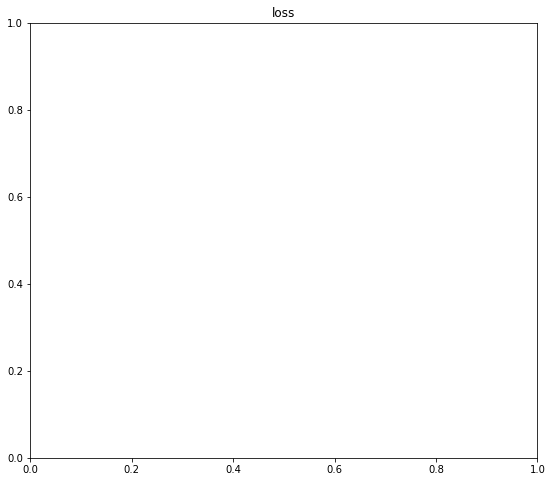

In [12]:
import matplotlib.pyplot as plt

metrics = ['loss']  # 使用する評価関数を指定

plt.figure(figsize=(20, 8))  # グラフを表示するスペースを用意

for i in range(len(metrics)):

    metric = metrics[i]

    plt.subplot(1, 2, i+1)  # figureを1×2のスペースに分け、i+1番目のスペースを使う
    plt.title(metric)  # グラフのタイトルを表示
    
    plt_train = history.history[metric][2:len(x_train)]  # historyから訓練データの評価を取り出す
    
    plt_test = history.history['val_' + metric][2:len(x_test)]
    # plt_test = history.history[metric][2:len(x_test)]  # historyからテストデータの評価を取り出す
    print(len(plt_train), len(plt_test))
    
    plt.plot(plt_train, label='training')  # 訓練データの評価をグラフにプロット
    plt.plot(plt_test, label='test')  # テストデータの評価をグラフにプロット
    
    
    plt.title("Error transition", fontsize=45)
    plt.xlabel('Number of Epoch', size = 35)
    plt.ylabel('Error', size = 35)
    plt.tick_params(labelsize=18)
    plt.legend(prop={"size": 25})  # ラベルの表示
    plt.savefig("C:/Users/g1723012/Desktop/abstract_template/500ex.eps")
    
    
plt.show()  